In [4]:
# initiation date: 2023-03-27

import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import constrNMPy
from pytensor import tensor as pt 
import os 

print(f"Running on PyMC v{pm.__version__}")

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# os.getcwd() 
os.chdir('/Users/abel/Desktop/Junior/CogMod/Assignments/H3') # change the working directory to the folder where the data is stored

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']

# set the style of the plots
az.style.use("arviz-white")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.1.2


# 第三次作业

**注意:**

1.本次作业有三道题，共计100分，请在JupyterLab中使用python或者R在本文档中完成本次作业。

2.请在做答时描述你的解题思路，并附上相应代码，我们将会根据结果的正确及清晰程度进行评分。
+ 请确保文字结果及代码清晰、易读。代码应有简要注释以及运行结果，运行结果应有相应的说明。图片结果应当有相应的标题。
+ 请注意：注释允许使用中文/英文，可以使用co-pilot自动生成的注释，但要求对关键语句进行详细的注释，包括但不限于选择该语句的原因、参数设置的原因等。
+ 代码的注释会纳入评分依据。

3.最终提交时请重命名作业中的ipynb文件。将运行好的结果导出成html，并将相应的文件打包上传，文件命名格式请参照 “作业N_编程语言(python或R)_本科⽣/研究⽣_姓名_学号 ”，使用英文和拼音，例：“homework3_python_undergraduate_zhangsan_1901111111”(本科生)或者“homework3_python_postgraduate_zhangsan_1901111111”(研究生) 。

## 题目一

有20名被试参加了一项技能测验，测验包括50道4选1的选择题。假设对于每名被试来说，答对每道题目的概率相同且相互独立，被试可以被分为熟手和新手两类，所有熟手答对每道题目的概率相同，所有新手答对每道题目的概率也相同，一组数据为"homework3_q1.csv"。


### Q1
请参考Assessment of malingering(Section 6.5 of Lee & Wagenmakers 2013)，使用贝叶斯方法对熟手和新手答对每道题目的概率$\psi_S$和$\psi_N$进行采样，分别画出它们采样的traceplot以及后验分布，并在分布中标注Highest Density Interval (HDI)。


----

#### 观察并建模

首先，载入数据并且简单观察一下，大致可以感觉到前十位选手应该是熟手.

但是在具体的实现中，可以将每个被试是新手还是熟手的概率定为一个随机变量 $z_i$，取值为0或者1，0表示第$i$个被试是新手，1表示第$i$个被试是熟手。

In [3]:
# load the data from the csv file and take a look
dt = pd.read_csv('homework3_q1.csv', header = 0 ) # load the data from the csv file

df_vis = dt
df_vis.style.bar(subset=['score'], color=pu, width=100)   # visualize the data with a bar plot indicating response

整个答题过程可以用以下的随机过程描述：
- 每个被试 $z_i$ 有 $\alpha$ 的可能性是熟手，$\alpha$ 未知，但应该在 $(0,1)$ 之间；
- 如果是熟手，被试对所有题目的答题正确率均为 $\psi_S$；如果是新手，则正确率为 $\psi_N$;
- 由于是四选一题目，而两组被试都有认真答题，那么取值范围应该皆大于0.25，而老手答题正确率应该高于新手， $\psi_S > \psi_N$;
- 由于每个被试答题正确率确定为 $\theta_i$，n道题目的答对数目符合 $(\theta_i, n)$ 的二项分布。

随机变量可由以下表达式体现：

$$ \psi^S \sim \text{Uniform}(0.25,1) $$
$$ \psi^N \sim \text{Uniform}(0.25,\psi^S) $$
$$ \alpha \sim \text{Uniform}(0,1) $$
$$ z_{i} \sim \text{Bernoulli}(\alpha) $$
$$   \theta_{i} \sim
\begin{cases}
\psi^S  & \text{if $z_{i} = 1$} \\
\psi^N  & \text{if $z_{i} = 0$}
\end{cases}  $$
$$ k_{i} \sim \text{Binomial}(\theta_{i},n) $$ 

根据要求使用Pymc进行建模，并且生成graphviz图，可以看到模型的结构如下：

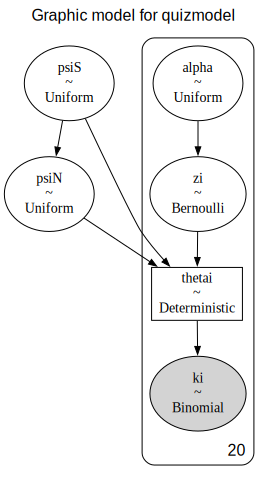

In [8]:
score = dt['score'].values # extract the score column
p = len(score)  # number of people
n = 50  # number of questions

with pm.Model() as quizmodel:
    # prior
    psiS = pm.Uniform("psiS", lower=0.25, upper=1)
    psiN = pm.Uniform("psiN", lower=0.25, upper=psiS)

    # latent
    alpha = pm.Uniform("alpha", lower=0, upper=1, shape=p)
    zi = pm.Bernoulli("zi", p=alpha, shape=p)
    theta = pm.Deterministic("thetai", pt.switch(zi, psiS, psiN))

    # observed
    ki = pm.Binomial("ki", p=theta, n=n, observed=score)

graphm = pm.model_to_graphviz(quizmodel) # model graph
graphm.graph_attr.update({
    'label': 'Graphic model for quizmodel',  # add label to the top
    'labelloc': 't',      # set label location to top
    'labeljust': 'c',     # set label justification to center
    'fontname':'Arial',   # set font to Arial
    'fontsize':'16'      # set font size to 16
})
graphm.node_attr.update({'fontsize': '14'})
graphm.edge_attr.update({'arrowsize': '0.8'})

graphm

#### 正式开始分析之前，先对目前设置的先验进行predictive check:
- $\psi_N$ 、$\psi_S$ 和 $\theta_i$ 看起来都和预期比较类似；
- 第四张子图中，根据prior预测得到的分数分布 $k_i$ （黄色）中，以紫色虚线标注了现有的可观测的分数值，似乎也是比较符合这个分布。

Sampling: [alpha, ki, psiN, psiS, zi]


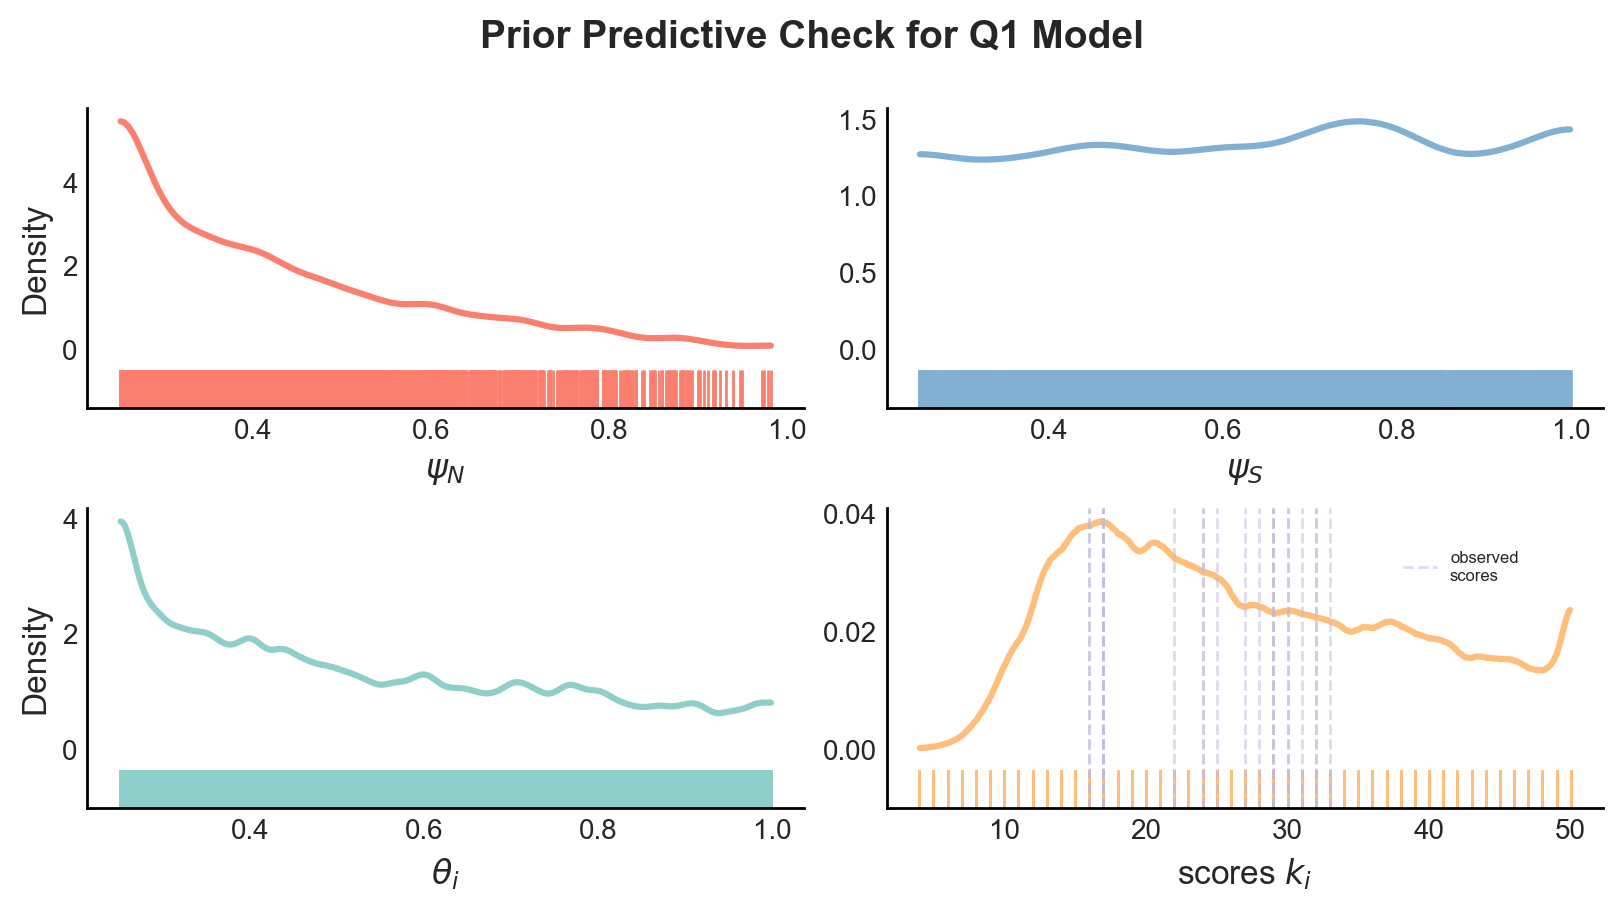

In [193]:
# Prior check

with quizmodel:
    prior_quizmodel = pm.sample_prior_predictive(samples=2000) # sample from the prior
    

# plot prior
az.style.use("arviz-white")
fig, axes = plt.subplots(2, 2, figsize=(8,4), dpi = 100);
fs = 12;

az.plot_dist(prior_quizmodel.prior["psiN"].values.flatten(), ax=axes[0,0], kind="kde", rug=True, color = re);
axes[0,0].set_xlabel(r"$\psi_N$", fontsize=fs);
axes[0,0].set_ylabel("Density", fontsize=fs);

az.plot_dist(prior_quizmodel.prior["psiS"].values.flatten(), ax=axes[0,1], kind="kde", rug=True, color = bl);
axes[0,1].set_xlabel(r"$\psi_S$", fontsize=fs);

az.plot_dist(prior_quizmodel.prior["thetai"].values.flatten(), ax=axes[1,0], kind="kde", rug=True, color = gr);
axes[1,0].set_xlabel(r"$\theta_i$", fontsize=fs);
axes[1,0].set_ylabel("Density", fontsize=fs);

# plot prior predictive
az.plot_dist(prior_quizmodel.prior_predictive["ki"].values.flatten(), ax=axes[1,1], kind="kde", rug=True, color = ye);
for li in range(len(score)):
    axes[1,1].axvline(x=score[li], color= pu, linestyle='--', linewidth=1, alpha = 0.5);
axes[1,1].axvline(x=score[0], color= pu, linestyle='--', linewidth=1, alpha = 0.5, label='observed\nscores');
axes[1,1].legend(bbox_to_anchor=(0.7, 0.7), fontsize=6)
axes[1,1].set_xlabel(r"scores $k_i$", fontsize=fs);


for ax in axes.flatten():
    ax.tick_params(axis='both', which='both', labelsize = 10) # set the tick size

fig.suptitle('Prior Predictive Check for Q1 Model', fontsize=14, fontweight='bold', fontfamily='arial', y=1.1)
plt.show()

#### 采样与绘制traceplot
设置slice，由于 $\psi_N$ 由 $\psi_S$ 所限制，所以先对 $\psi_S$ 采样，之后是$\psi_N$，之后才是每个人是熟手的概率 $\alpha$。

In [9]:
with quizmodel:
    step = pm.Slice([psiS, psiN, alpha])
    quiz_trace = pm.sample(step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [psiS]
>>Slice: [psiN]
>>Slice: [alpha]
CompoundStep
>CompoundStep
>>Slice: [psiS]
>>Slice: [psiN]
>>Slice: [alpha]
>BinaryGibbsMetropolis: [zi]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


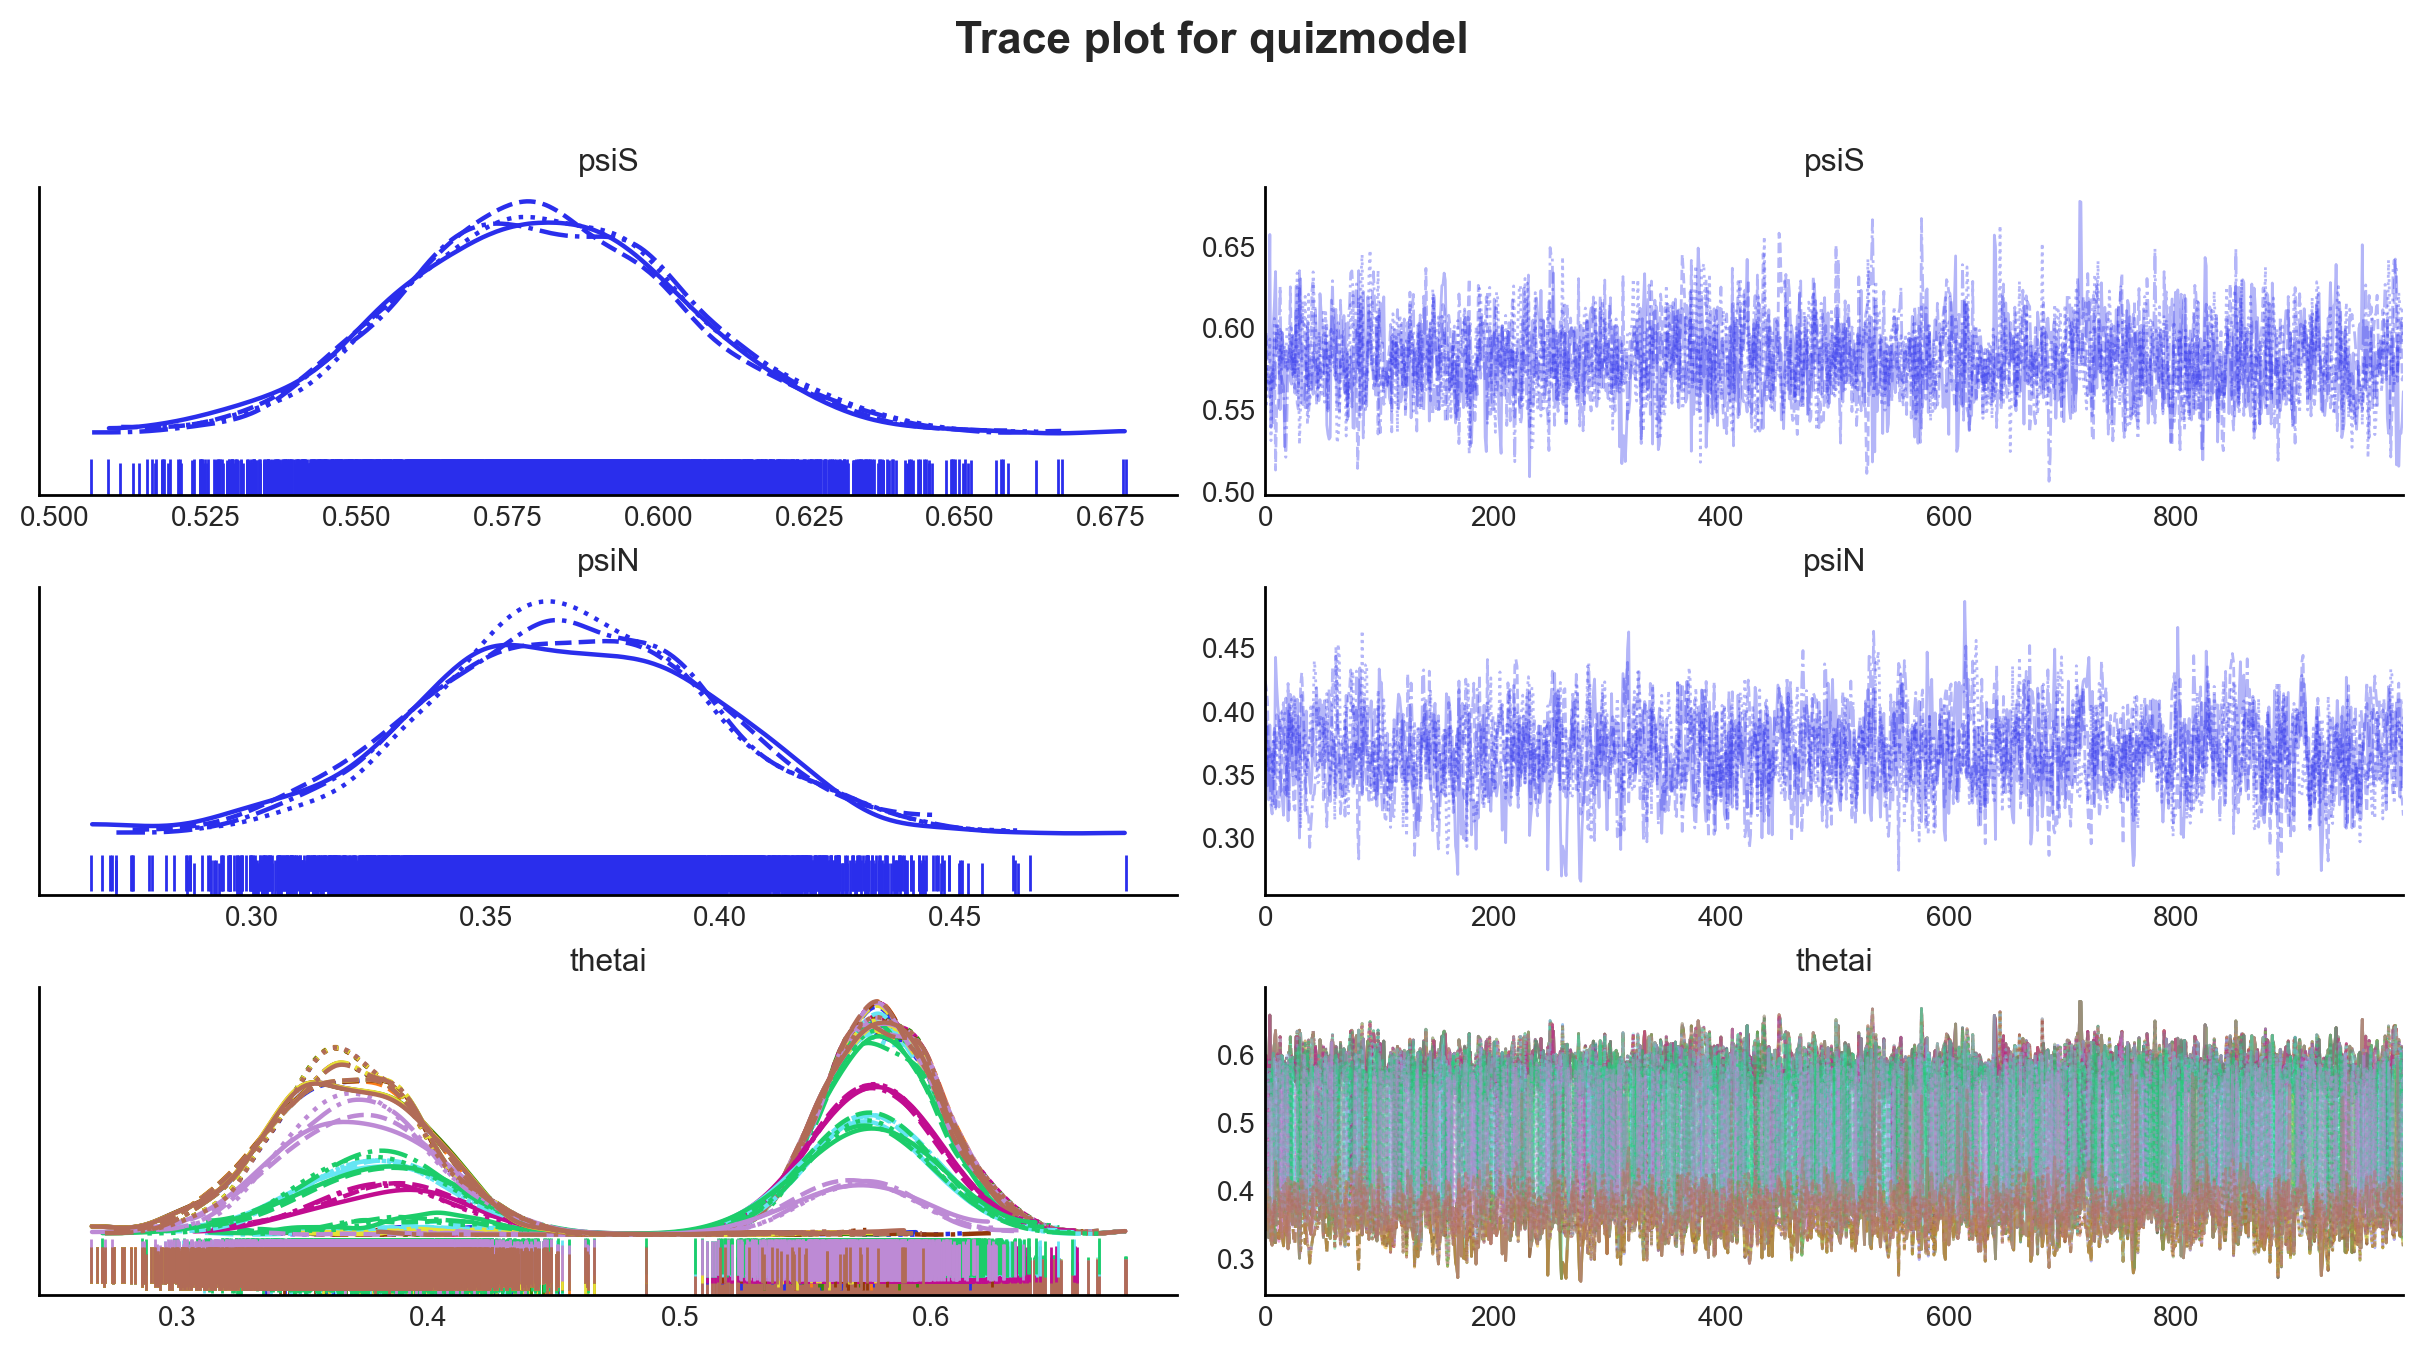

In [190]:
# Trace plot
az.plot_trace(quiz_trace, var_names=["psiS", "psiN",'thetai'], compact=True, rug=True,
              trace_kwargs = {'linewidth':1});

sns.set_context("talk");
sns.set_style("ticks");
plt.suptitle('Trace plot for quizmodel', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);
plt.show()
az.style.use("arviz-white");

#### 绘制后验分布

现在绘制后验分布与标注HDI。

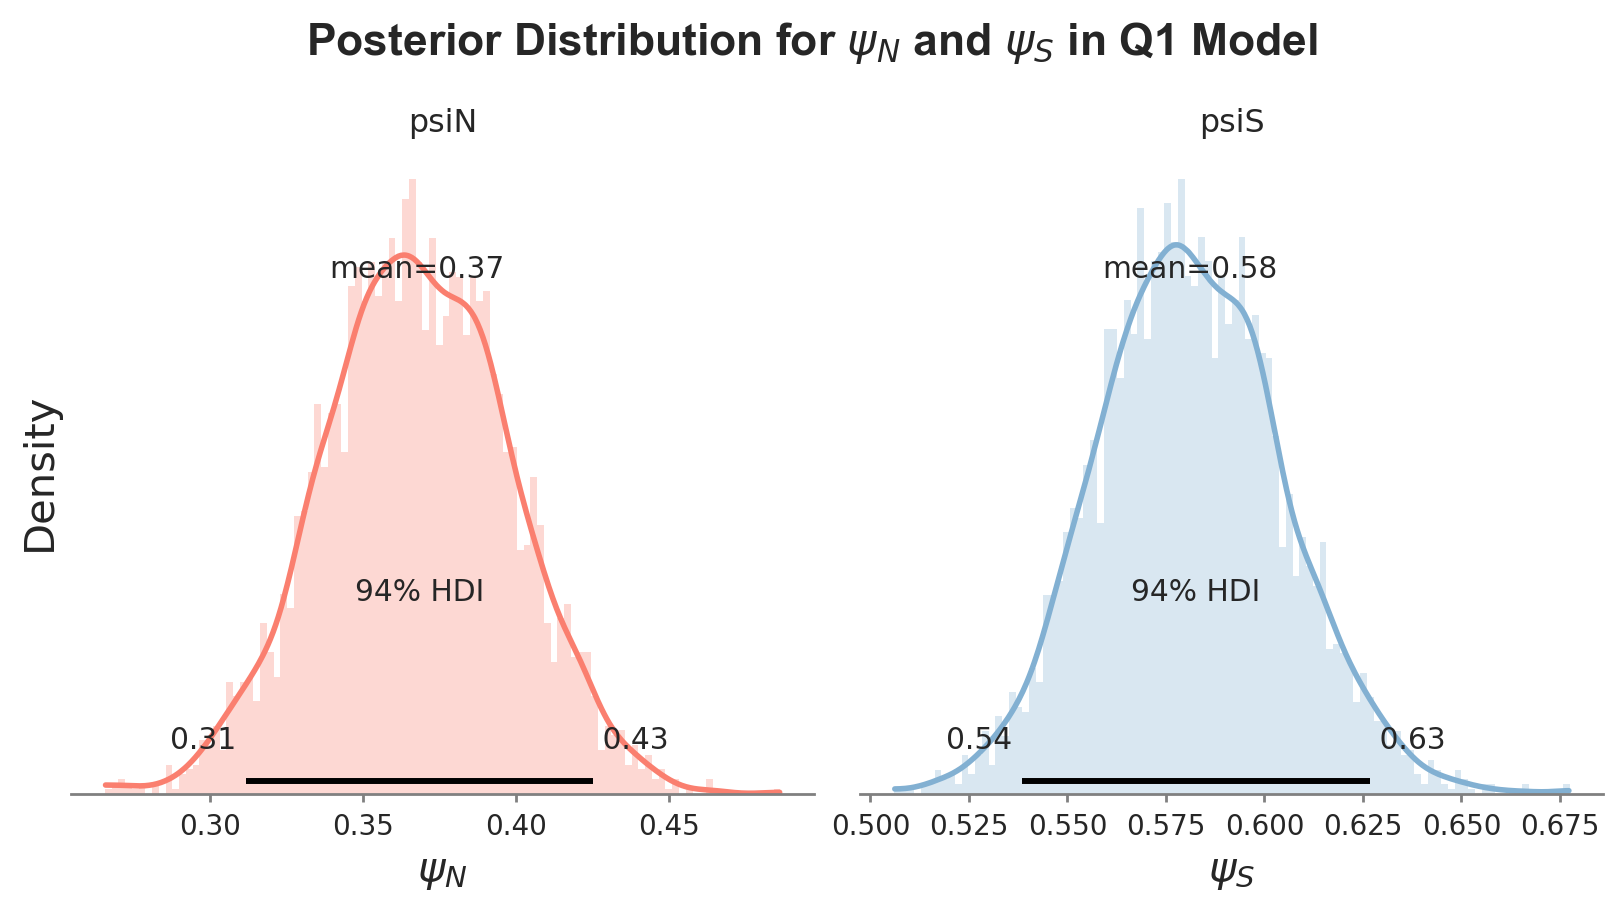

In [13]:
az.style.use("arviz-white");
fig, axes = plt.subplots(1, 2, figsize=(8,4), dpi=100);

[posterior_psiN, posterior_psiS] = [quiz_trace.posterior["psiN"].values.flatten(), quiz_trace.posterior["psiS"].values.flatten()];    # read posterior samples and flatten
az.plot_kde(posterior_psiN, ax=axes[0], plot_kwargs={"color": re, "linewidth": 2});
axes[0].hist(posterior_psiN, bins=100, density=1, alpha=0.3, color=re);
axes[0].set_ylabel("Density");

az.plot_kde(posterior_psiS, ax=axes[1], plot_kwargs={"color": bl, "linewidth": 2});
axes[1].hist(posterior_psiS, bins=100, density=1, alpha=0.3, color=bl);

az.plot_posterior(quiz_trace, var_names=["psiN"], ax=axes[0], color=re, textsize=10);
axes[0].set_ylabel("Density");
axes[0].set_xlabel("$\psi_N$");

az.plot_posterior(quiz_trace, var_names=["psiS"], ax=axes[1], color=bl, textsize=10);
axes[1].set_xlabel("$\psi_S$");

fig.suptitle('Posterior Distribution for $\psi_N$ and $\psi_S$ in Q1 Model', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1)
plt.show()

### Q2
请以合理的方式画出$\psi_S$和$\psi_N$的联合后验分布。

#### 绘制联合后验分布
采用az.plot_pair()函数，可以将两个参数的后验分布绘制在一起。

$\psi_S$ 和 $\psi_N$ 各自的后验分布都类似于高斯分布，而且 $\psi_S$ 的后验分布的均值比 $\psi_N$ 的后验分布的均值要大，这也符合我们的预期。

联合分布如图所示：

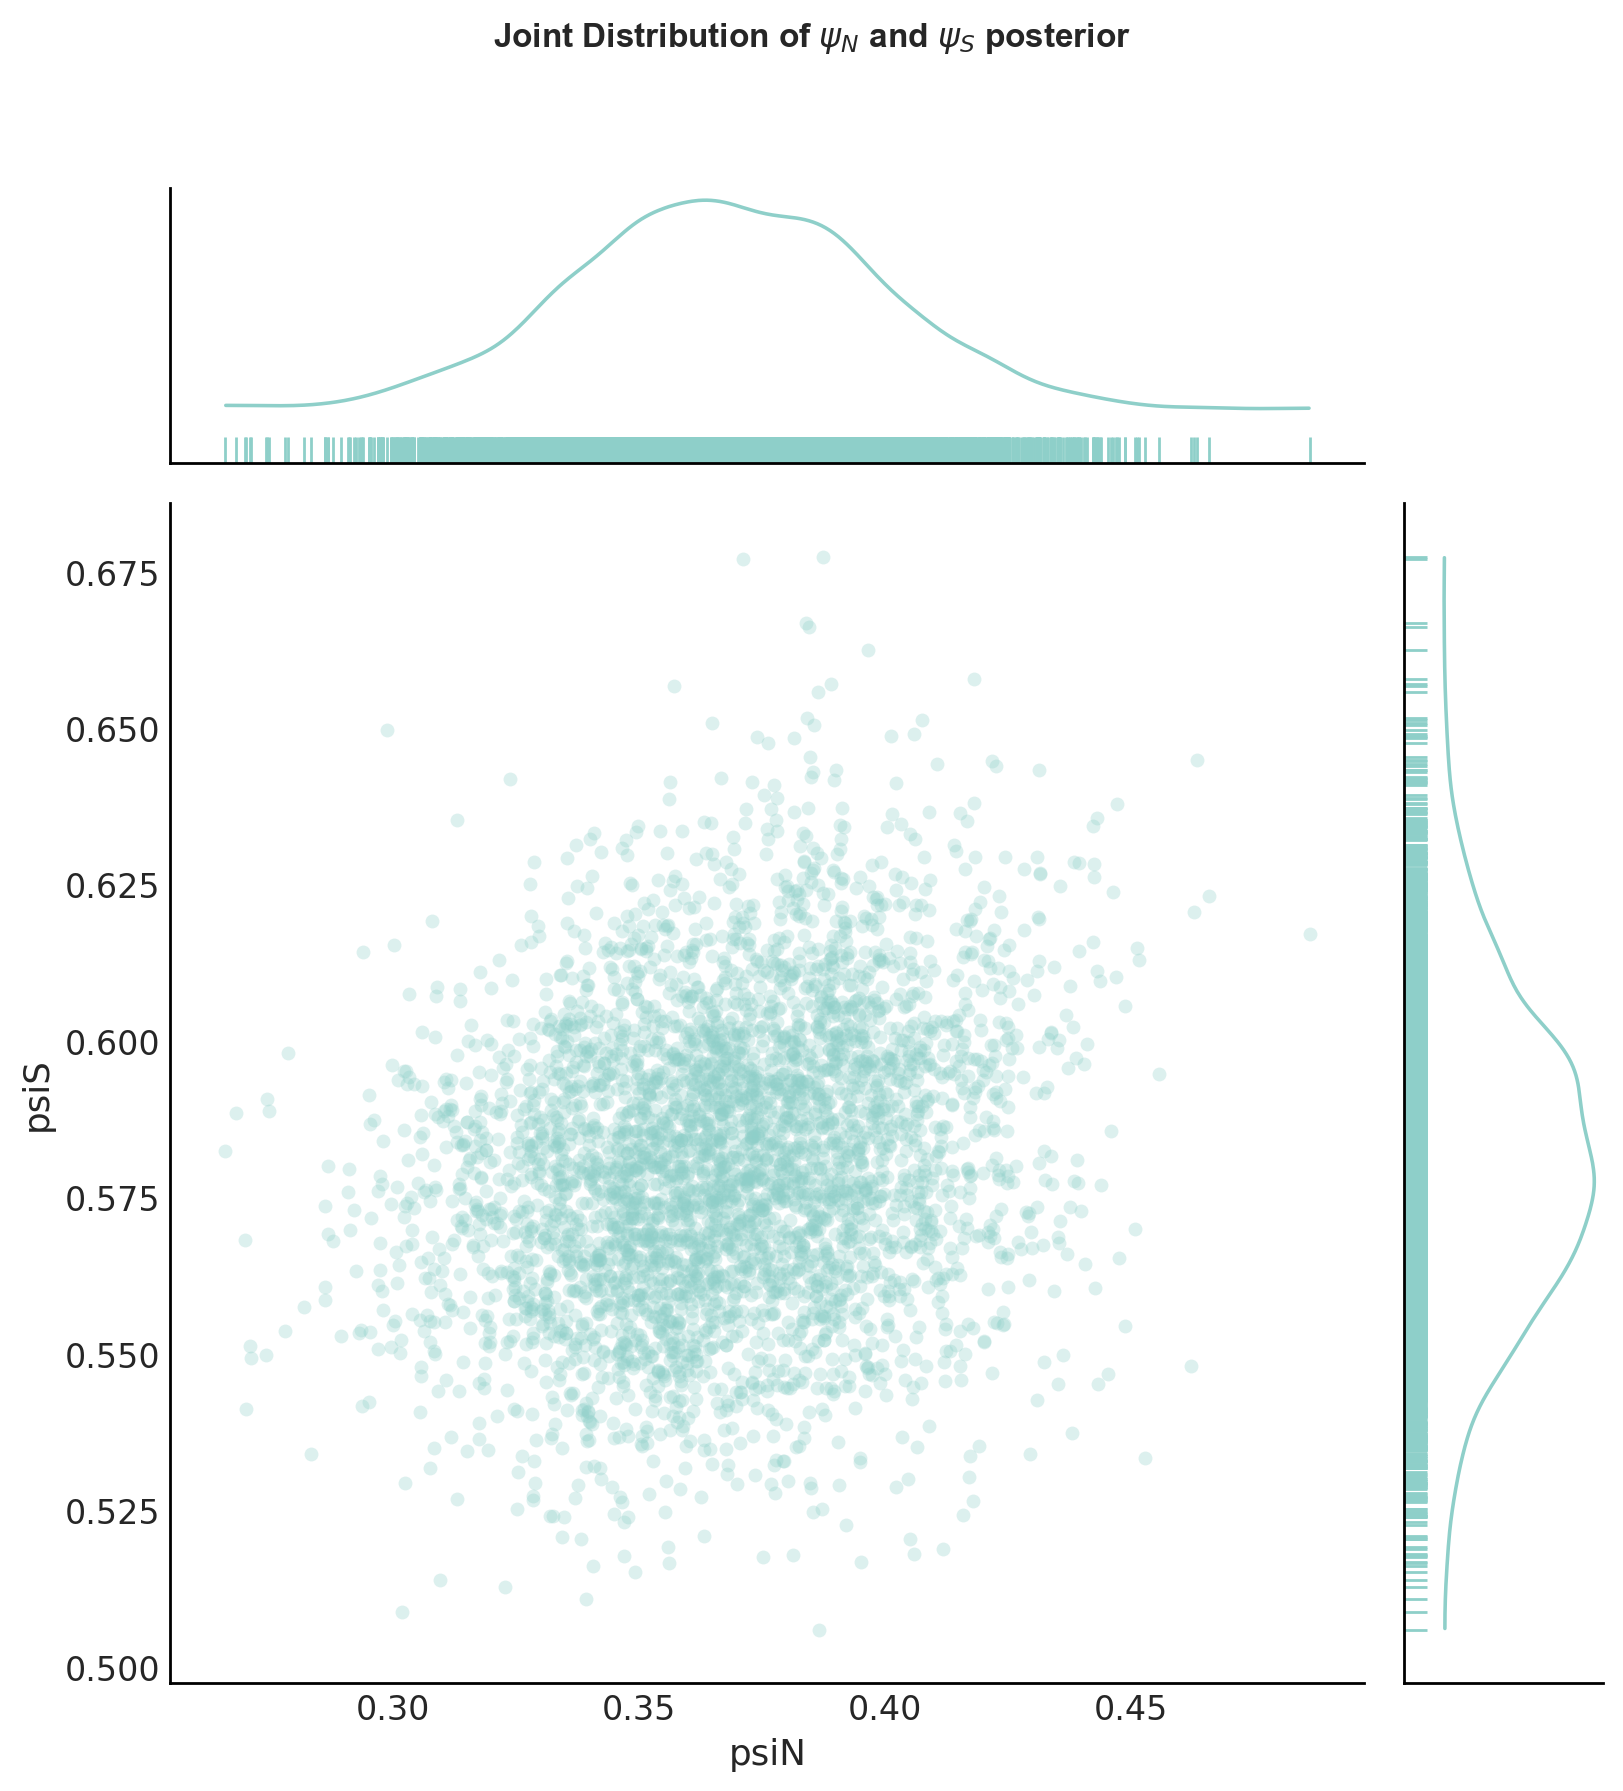

In [19]:
az.style.use("arviz-white")
az.plot_pair(quiz_trace, var_names=["psiN", "psiS"], kind='scatter', scatter_kwargs={'color':gr, 'alpha':0.3, 's':100}, 
             marginals=True, marginal_kwargs={'color':gr, 'rug':True},
             textsize=12, figsize=(8,8));

plt.suptitle('Joint Distribution of $\psi_N$ and $\psi_S$ posterior', fontsize=12,  fontweight='bold', fontfamily='arial', y=1.1)
plt.show()

### Q3
请画出每名被试是熟手的后验概率。

#### 绘制后验分布

由于在第一问中，我们给每名被试都设置了可能为熟手的先验 $\alpha_i$，所以在这里，我们可以直接绘制每个被试是熟手的概率，即 $\alpha_i$ 的后验概率。
并且标注出其中的94%HDI。

同时，采用0.5作为参照点进行比对，观测在哪些被试中，熟手的概率大于0.5的占比更多，哪些被试中，熟手的概率小于0.5占比更多，对每名被试的真实身份进行预测。

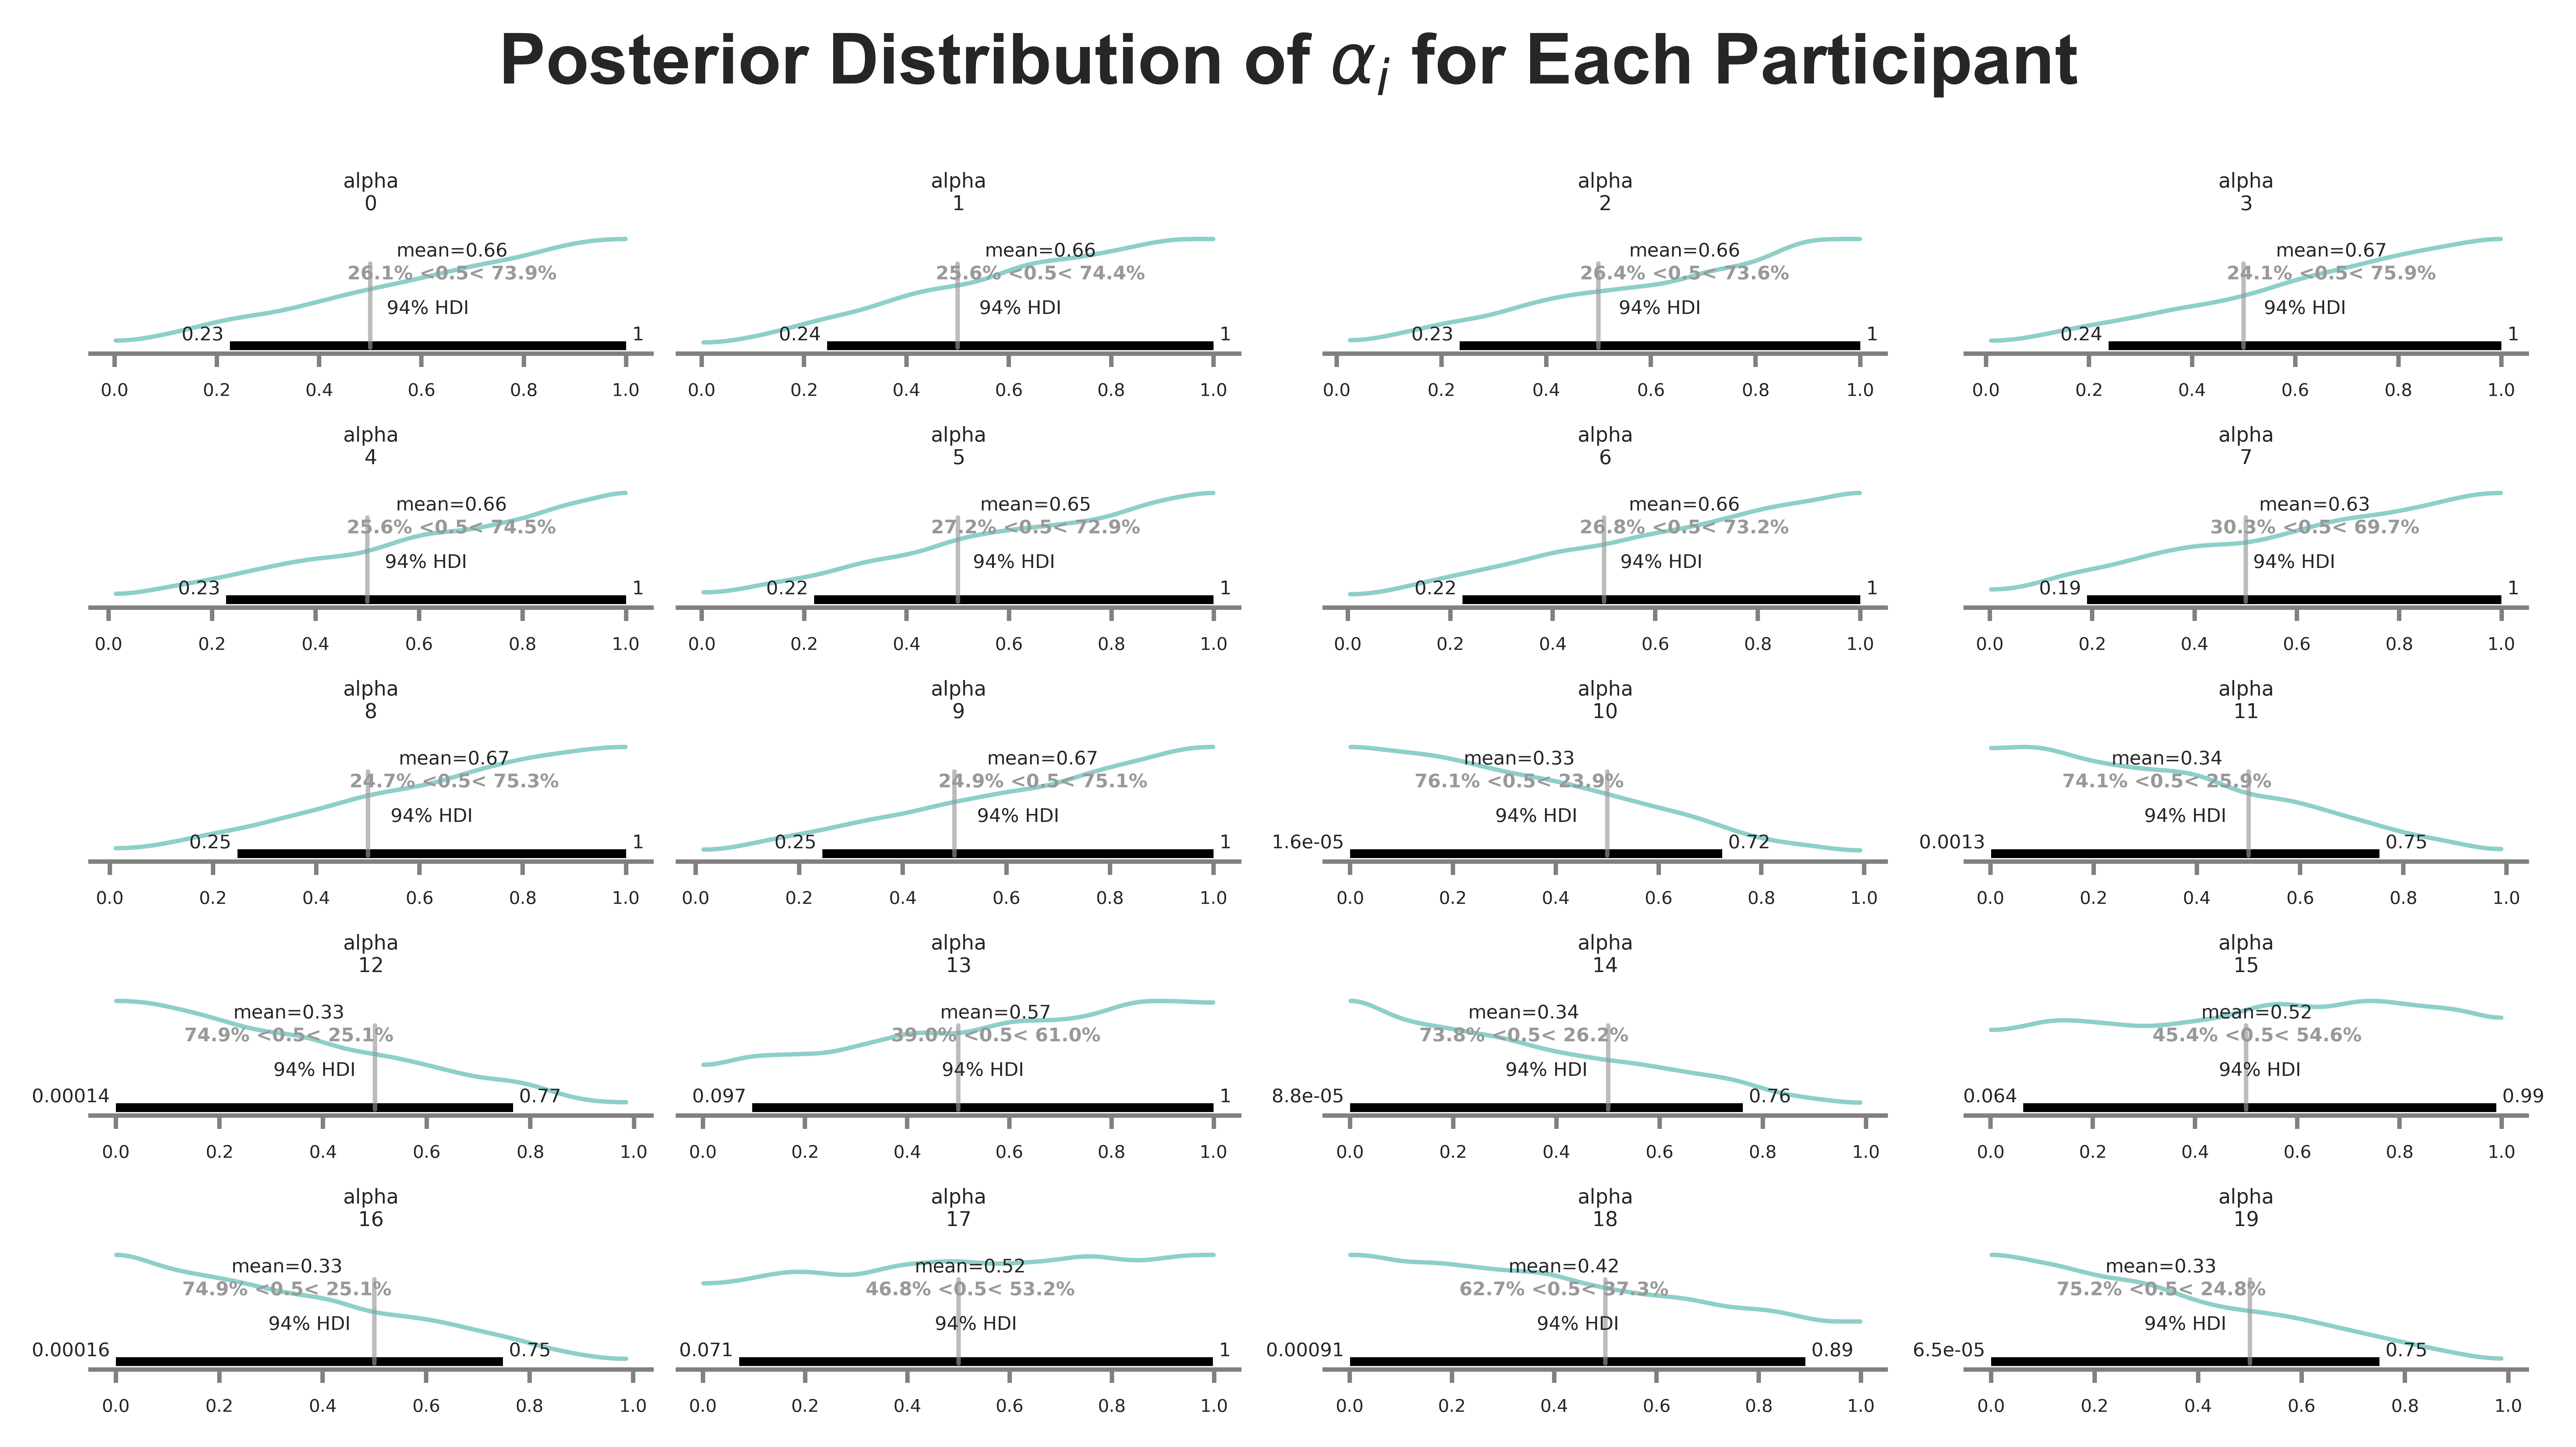

In [53]:
# posterior distribution of each alpha
fig, axes = plt.subplots(5, 4, figsize=(8,4), dpi=500);
az.plot_posterior(quiz_trace, var_names=["alpha"],ref_val=0.5, ref_val_color=ak, color=gr, textsize=4, ax=axes, linewidth=1);
fig.suptitle('Posterior Distribution of $\\alpha_i$ for Each Participant', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1)
plt.show()

我们也可以通过绘制每名被试 $z_i$ 的后验概率，来观察每名被试的真实身份，其中，$z_i = 1$ 表示第$i$个被试是熟手，$z_i = 0$ 表示第$i$个被试是新手。

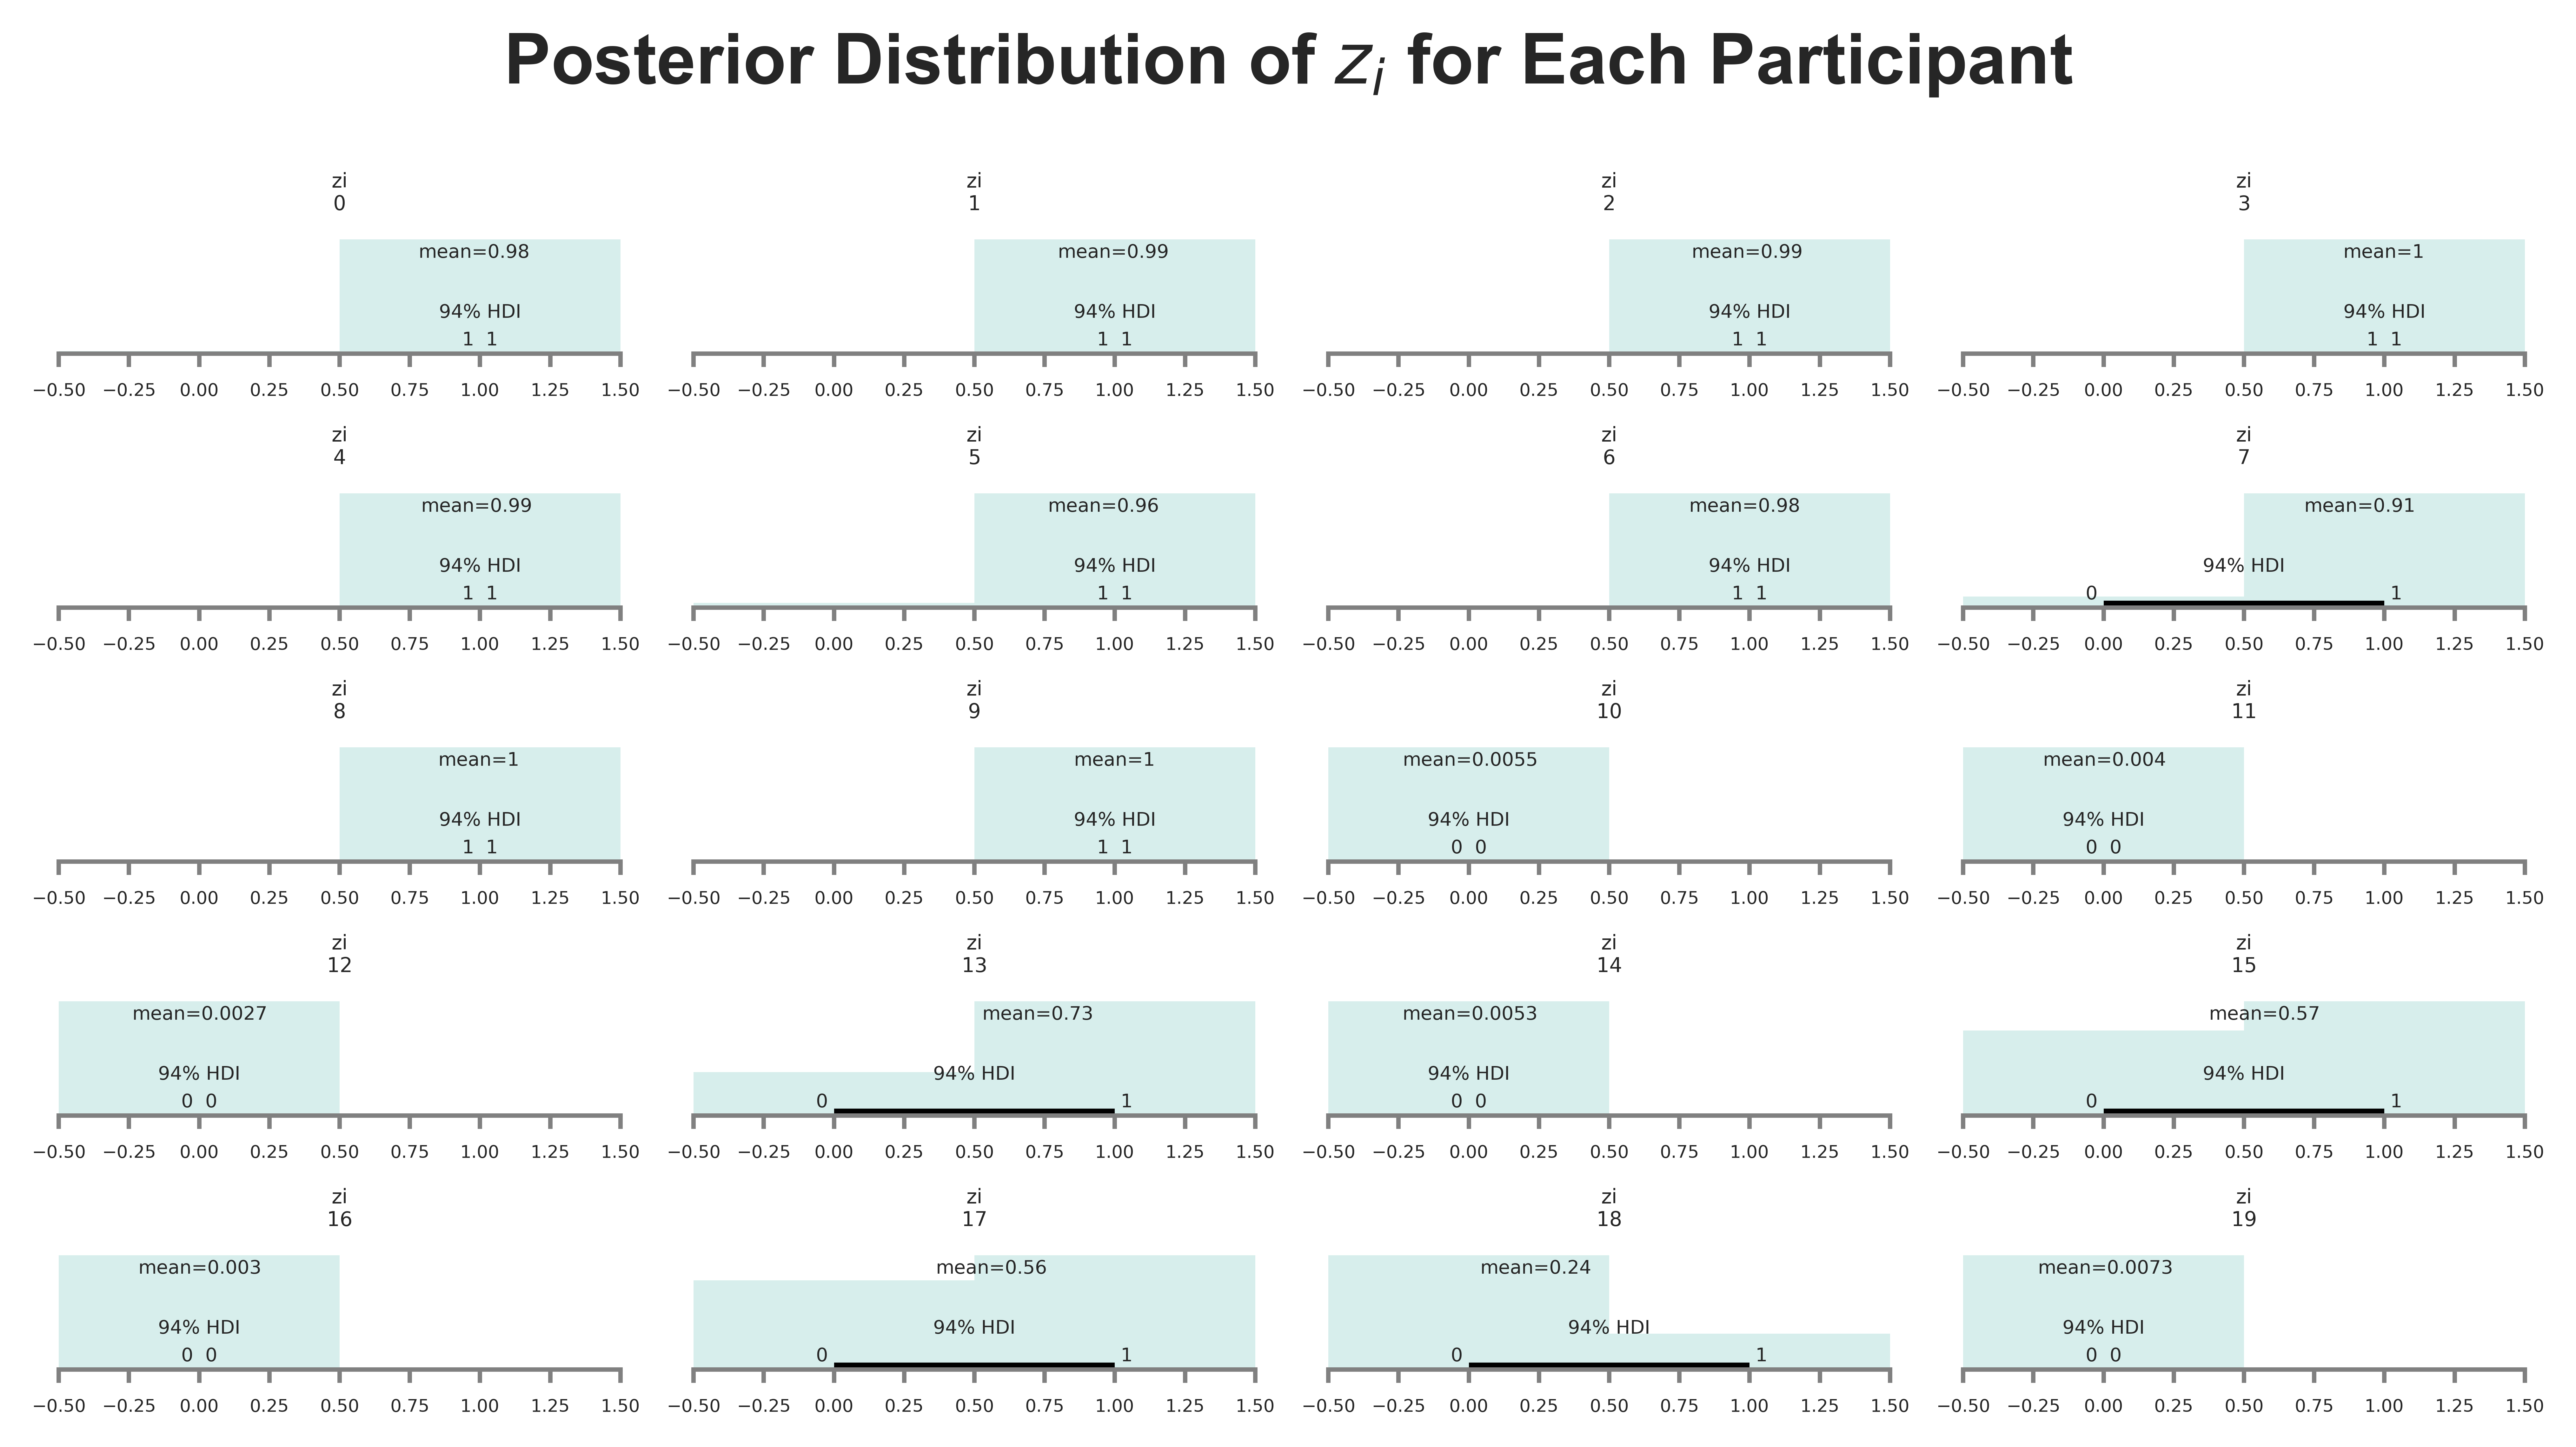

In [54]:
# posterior distribution of each zi
fig, axes = plt.subplots(5, 4, figsize=(8,4), dpi=500);
az.plot_posterior(quiz_trace, var_names=["zi"], color=gr, textsize=4, ax=axes, linewidth=1);
fig.suptitle('Posterior Distribution of $z_i$ for Each Participant', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1)
plt.show()

#### 报告

在此为基础上，我们可以对每名被试的真实身份进行预测，将每名被试的身份（'New','Skilled'）打印出来，同时报告他们的答题正确率，进行一定的检验。

In [67]:
accuracy = quiz_trace.posterior["thetai"].mean(dim=["chain", "draw"]).values.flatten()
NScate = (np.round(quiz_trace.posterior["zi"].mean(dim=["chain", "draw"]).values.flatten()))
states = ['New','Skilled']
NSstate = [states[int(i)] for i in NScate]
# for i in range(len(NScate)):
#     print('Partciipant', i+1, 'is', states[int(NScate[i])], 'in the test,' 'with an accuracy of', round(Skillprob[i],4),'and a final score of', round(score[i],2),'.')
report_table = pd.DataFrame({'Participant ID': np.arange(1,21), 'Performance': NSstate, 'Accuracy': accuracy, 'Final Score': score})
report_table
          

Participant ID Performance  Accuracy  Final Score
0                1     Skilled  0.577200           29
1                2     Skilled  0.580317           31
2                3     Skilled  0.579745           30
3                4     Skilled  0.580771           32
4                5     Skilled  0.578739           30
5                6     Skilled  0.573424           28
6                7     Skilled  0.577985           29
7                8     Skilled  0.563990           27
8                9     Skilled  0.580425           32
9               10     Skilled  0.580934           33
10              11         New  0.368685           17
11              12         New  0.368314           16
12              13         New  0.368156           16
13              14     Skilled  0.524648           25
14              15         New  0.368593           17
15              16     Skilled  0.491929           24
16              17         New  0.368230           17
17              18     Skilled  0.489882           24
18              19         New  0.419369           22
19              20         New  0.368991           17

## 题目二 

Alice参加一个选择题测验，每次测验包含99道单选题，每道题有4个选项，4个选项中有且仅有一个选项正确。进行测验时，每答对一道题计1分，答错一道题计0分，每次测验总分99分。测验总共进行10次，去除分数最高的2次与最低的2次后，以中间的6次作为最终成绩。假设每次测验中，Alice答对每个题目的概率相同，且在不同题目上和不同测验上的成绩都相互独立。已知Alice最终的成绩分别为22，25，30，38，40，48分。设Alice对单个题目的正确率为$\theta$。\
（可以参考Lee & Wagenmakers (2013)书Section 5.5中Cha Sa-soon的例子）

### Q1
用MLE的方法估计$\theta$，请在答案中
1. 写出$\theta$的log likelihood function；
2. 画出log likelihood随$\theta$变化的函数图像；
3. 报告$\theta$的MLE估计值。

---

#### MLE估计参数

根据题意，假设每道题目的正确率相同且为 $\theta$，则每道题目答对的概率为 $\theta$，答错的概率为 $1-\theta$。设 $X_i$ 表示 Alice 在第 $i$ 次测验中答对的题目数，则 $X_i$ 服从二项分布 $Binomial(99,\theta)$。则第 $i$ 次测验中的总分 $Y_i$ 可以表示为 $Y_i = X_i$。

根据题目中的要求，去除最高的2次与最低的2次后，剩下的6次测验的得分为 $Y_{(3)}, Y_{(4)}, \ldots, Y_{(8)}$，其中 $Y_{(k)}$ 表示第 $k$ 小的得分。则 Alice 的最终得分为 $\sum_{i=3}^8 Y_{(i)}$。

根据最大似然估计的方法，我们可以求出 $\theta$ 的最大似然估计值 $\hat{\theta}$，使得观测数据的联合概率密度函数 $f(\boldsymbol{y};\theta)$ 在 $\theta=\hat{\theta}$ 处取得最大值。其中 $\boldsymbol{y}=(y_1,\ldots,y_6)$ 是观测到的 Alice 的最终得分数据。

具体实现如下：
- 可观测的数据可以通过构建二项分布 $Binomial(99,\theta)$ 生成，求出可观测分数的似然；
- 对于未观测数据，可以将其可能的取值范围内的似然求和，作为该数据点的可能性。
- 采用Nelder-Mead算法求解最大似然估计值 $\hat\theta$。
- 代码实现如下：

In [8]:
# Define the MLE model

def censor_MLE(theta, LL, Ltime, UL, Utime, questnum = 99):
    '''Censor the parameter vector.
    Input:
        theta: the parameter vector
        LB: the lower bound of the observed data
        Ltime: the time when the lower bound is reached
        UB: the upper bound of the observed data
        Utime: the time when the upper bound is reached
    Output:
        lower + upper: the log-likelihood of the lower and upper bounds
    '''
    binom = stats.binom(questnum,theta) # Binomial distribution
    lowrang = np.arange(0, LL+1)
    upprang = np.arange(UL, questnum+1)
    L_likelihood = 0; U_likelihood = 0;
    L_likelihood = np.sum(binom.pmf(lowrang))
    U_likelihood = np.sum(binom.pmf(upprang))
    return (np.log(L_likelihood)*Ltime + np.log(U_likelihood)*Utime) # log-likelihood of the lower and upper bounds

def nll_test(theta, allscores , questionnum = 99):
    '''Negative log-likelihood function for the test data.
    Input:
        theta: the parameter vector
        allscores: the test data in a list
    Output:
        nll: the negative log-likelihood
    '''
    nll = 0; 
    UL = 48; LL = 22; Utime = 2; Ltime = 2;
    testtimes = len(allscores);
    nll += -np.sum(np.log(stats.binom(questionnum,theta).pmf(allscores)))
    nll += -censor_MLE(theta, LL, Ltime, UL, Utime)

    return nll

In [9]:
obscore = [22, 25, 30, 38, 40, 48]
questionnum = 99

# Use multiple random starting points to increase the probability of finding the global minimum.
import time
start = time.time()
args = (obscore)
LB = [0.25];
UB = [1];

# give it a try using intial parameters
from scipy.optimize import minimize
model_params = [0.3]
model_params_est = minimize(nll_test, model_params, args=args, method='Nelder-Mead', tol=1e-6).x

# use multiple ranom starting point to find the global minimum
N_random=10
optimal=[]
for i in range(N_random):
    theta = np.random.uniform(0.25, 1, 1); # random starting point
    LB = [0.25]; UB = [1];
    xopt = constrNMPy.constrNM(nll_test, theta, LB=LB, UB=UB, args = [args], full_output=True)
    optimal.append(xopt['xopt'])
y = list(map(lambda params: nll_test(theta, args), optimal)) # optional: use full output from constrNM
opt = optimal[y.index(min(y))]
print('Estimated parameters using MLE: theta = ' + str(*opt))

Estimated parameters using MLE: theta = 0.34670694431797733


绘制loglikihod随$\theta$变化的函数图像：

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:33: RuntimeWarning: divide by zero encountered in log
  nll += -np.sum(np.log(stats.binom(questionnum,theta).pmf(allscores)))
/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:20: RuntimeWarning: divide by zero encountered in log
  return (np.log(L_likelihood)*Ltime + np.log(U_likelihood)*Utime) # log-likelihood of the lower and upper bounds


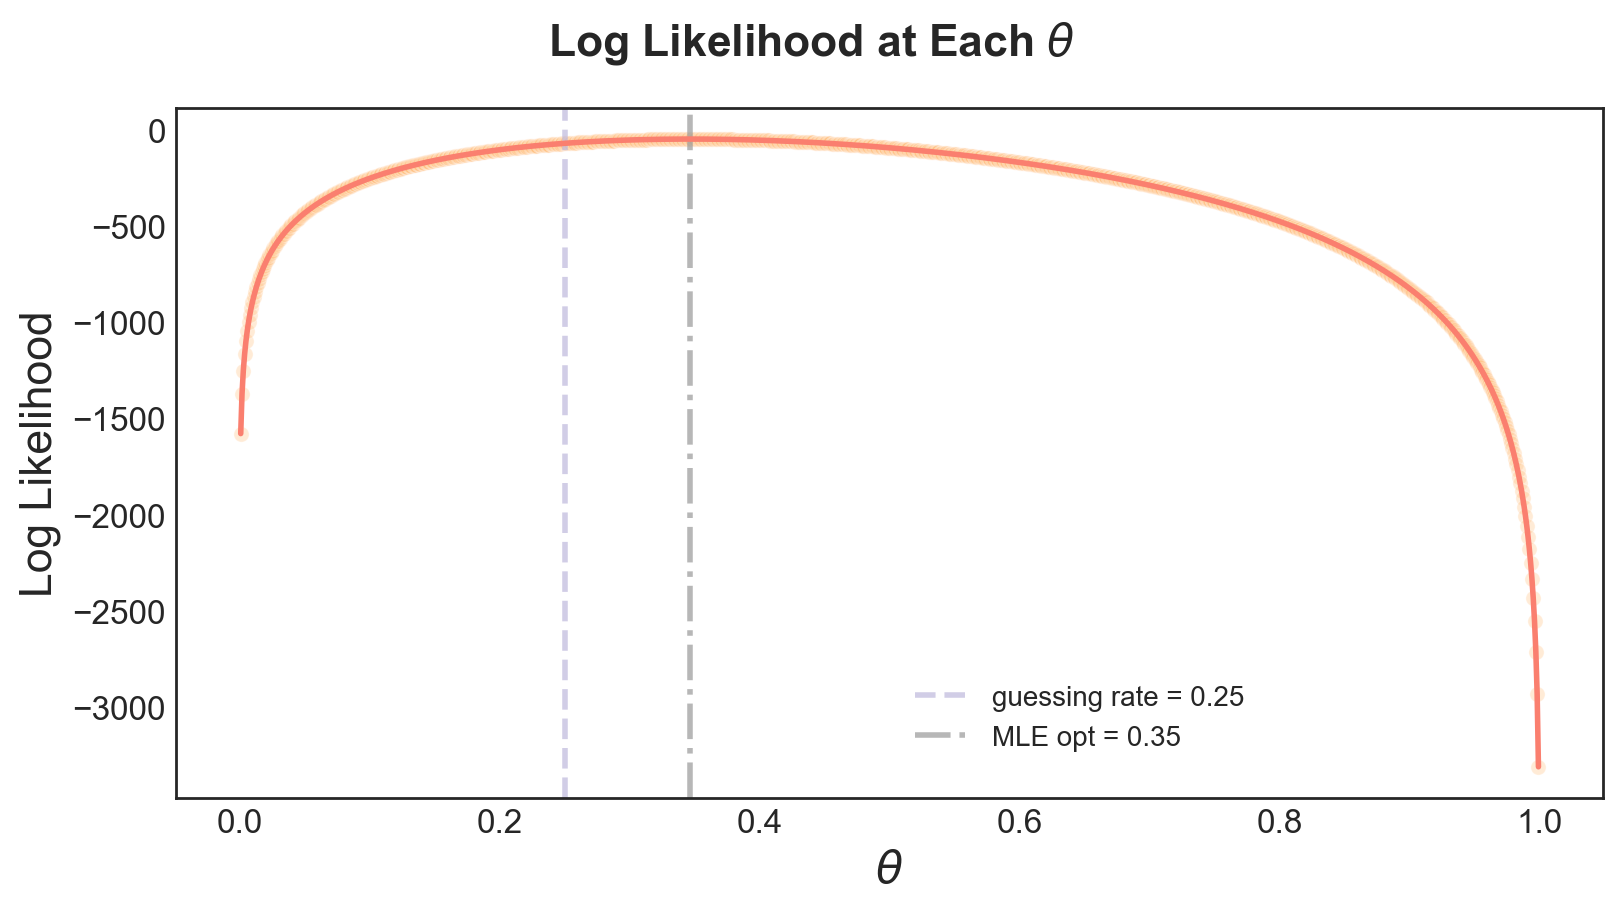

In [10]:
theta_lst = np.linspace(0,1,1000);
ll_lst = [];

for ti in range(len(theta_lst)):
    ll_lst.append(-nll_test(theta_lst[ti], obscore));

# plot the likelihood function
sns.set_style("white");
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=100);
df = pd.DataFrame({'theta':theta_lst, 'likelihood':ll_lst});
sns.scatterplot(x='theta', y='likelihood', data=df, s=30, color=ye, alpha=0.3, ax=axes);
axes.axvline(x=0.25, color= pu, linestyle='--', linewidth=2, alpha = 0.7, label='guessing rate = 0.25');
axes.axvline(x=model_params_est, color= ak, linestyle='-.', linewidth=2, alpha = 0.7, label='MLE opt = %.2f'%(model_params_est));
axes.set_xlabel('$\\theta$', fontsize=16);
axes.set_ylabel('Log Likelihood', fontsize=16);
axes.tick_params(axis='both', which='both', labelsize = 12) # set the tick size
plt.plot(df['theta'], df['likelihood'], color = re, alpha = 1, linewidth = 2);
plt.legend(bbox_to_anchor=(0.5, 0.2), fontsize=10);

plt.suptitle('Log Likelihood at Each $\\theta$', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);
plt.show()

由于本题的例子中，参数在大部分范围内的取值可能会导致Likelihood极低（如$\theta$取0.8之后），影响中间范围内的Likelihood显得比较平稳。我们额外直接绘制了likelihood随$\theta$变化的函数图像，更直观地感受到likelihood的变化与最高点。

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:33: RuntimeWarning: divide by zero encountered in log
  nll += -np.sum(np.log(stats.binom(questionnum,theta).pmf(allscores)))
/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:20: RuntimeWarning: divide by zero encountered in log
  return (np.log(L_likelihood)*Ltime + np.log(U_likelihood)*Utime) # log-likelihood of the lower and upper bounds


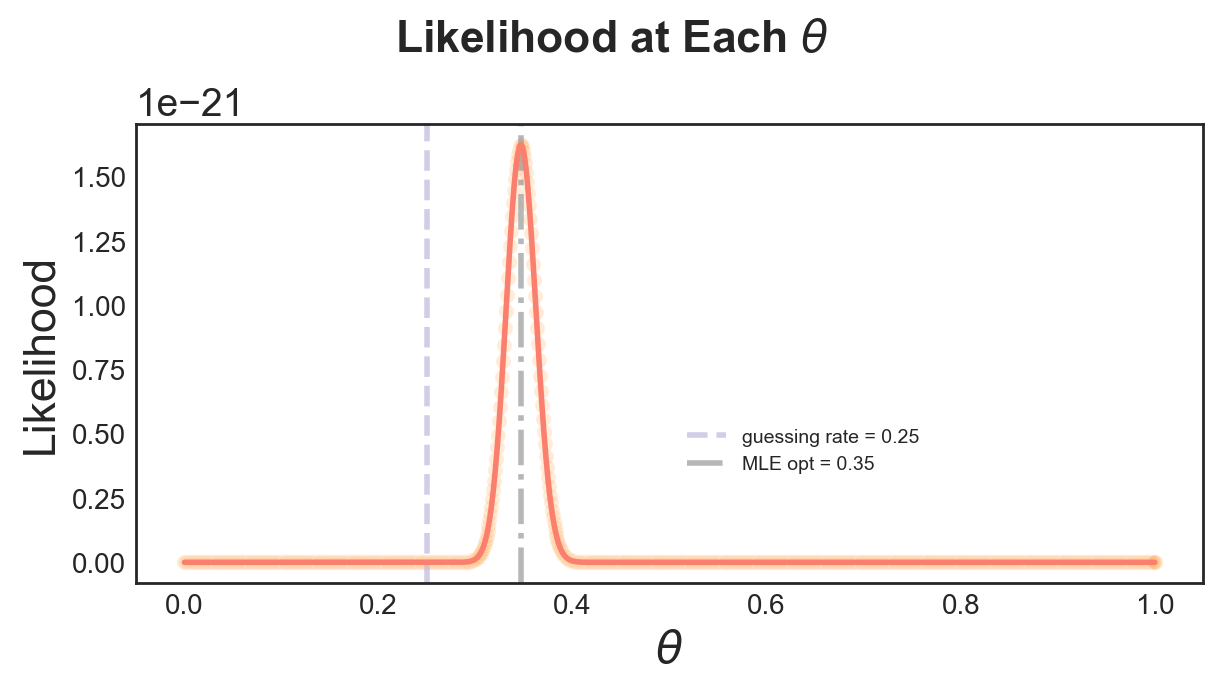

In [17]:
theta_lst = np.linspace(0,1,1000);
likelihood_lst = [];

for ti in range(len(theta_lst)):
    likelihood_lst.append(np.exp(-nll_test(theta_lst[ti], obscore)));

# plot the likelihood function
sns.set_style("white");
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=100);
df = pd.DataFrame({'theta':theta_lst, 'likelihood':likelihood_lst});
sns.scatterplot(x='theta', y='likelihood', data=df, s=30, color=ye, alpha=0.3, ax=axes);
axes.axvline(x=0.25, color= pu, linestyle='--', linewidth=2, alpha = 0.7, label='guessing rate = 0.25');
axes.axvline(x=model_params_est, color= ak, linestyle='-.', linewidth=2, alpha = 0.7, label='MLE opt = %.2f'%(model_params_est));
axes.set_xlabel('$\\theta$', fontsize=16);
axes.set_ylabel('Likelihood', fontsize=16);
axes.tick_params(axis='both', which='both', labelsize = 10) # set the tick size
plt.plot(df['theta'], df['likelihood'], color = re, alpha = 1, linewidth = 2);
plt.legend(bbox_to_anchor=(0.5, 0.2), fontsize=7);

plt.suptitle('Likelihood at Each $\\theta$', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);
plt.show()

### Q2
用Bayesian inference的方法估计$\theta$，设$\theta$的先验分布为$\alpha=2,\beta=5$的$Beta$分布，即$\theta\sim \text{Beta}(2, 5)$，请在答案中
1. 利用MCMC对$\theta$进行采样，画出$\theta$的后验分布；
2. 报告$\theta$的Bayesian inference估计值。

#### 分析条件与建模

这个过程中，可以认为99道题目答对正确的数目X服从二项分布$Binomial(99,\theta)$，共进行10次这样的过程得到 $X_i (i = 1,2...10)$。

而$\theta$是一个随机变量，其分布为$Beta(2,5)$。


即，我们现在已知：
$$ \theta \sim Beta(2,5) $$
$$ X_i \sim Binomial(99,\theta) $$


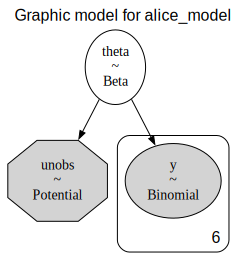

In [18]:
def censor(theta, LL, Ltime, UL, Utime, questnum = 99):
    '''Censor the parameter vector.
    Input:
        theta: the parameter vector
        LB: the lower bound of the observed data
        Ltime: the time when the lower bound is reached
        UB: the upper bound of the observed data
        Utime: the time when the upper bound is reached
    Output:
        lower + upper: the log-likelihood of the lower and upper bounds
    '''
    binom = pm.Binomial.dist(n=questnum, p=theta)
    lowrang = np.arange(0, LL+1)
    upprang = np.arange(UL, questnum+1)
    L_likelihood = 0; U_likelihood = 0;
    L_likelihood = pm.logsumexp(pm.logp(binom, lowrang)) * Ltime
    U_likelihood = pm.logsumexp(pm.logp(binom, upprang)) * Utime
    return  L_likelihood + U_likelihood

with pm.Model() as alice_model:
    # prior
    theta = pm.Beta('theta', alpha=2, beta=5)
    
    # observed likelihood
    y = pm.Binomial('y', n=99, p=theta, observed=obscore)
    # censoring
    unobs = pm.Potential('unobs', censor(theta, 22, 2, 48, 2))
    
graphm = pm.model_to_graphviz(alice_model) # model graph
graphm.graph_attr.update({
'label': 'Graphic model for alice_model',  # add label to the top
'labelloc': 't',      # set label location to top
'labeljust': 'c',     # set label justification to center
'fontname':'Arial',   # set font to Arial
'fontsize':'16'      # set font size to 16
})
graphm.node_attr.update({'fontsize': '14'})
graphm.edge_attr.update({'arrowsize': '0.8'})

graphm

简单进行prior predictive check，看看prior的分布是否合理，以及由prior预测的分数分布是否与现有数据一致。

可以观测到，当前的prior聚集在0.25左右，预测的分数也可以较好的覆盖现有数据，可以认为设置的比较合理。

#### Prior predictive check

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1417229456.py:3: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_alice = pm.sample_prior_predictive() # sample from the prior distribution
Sampling: [theta, y]


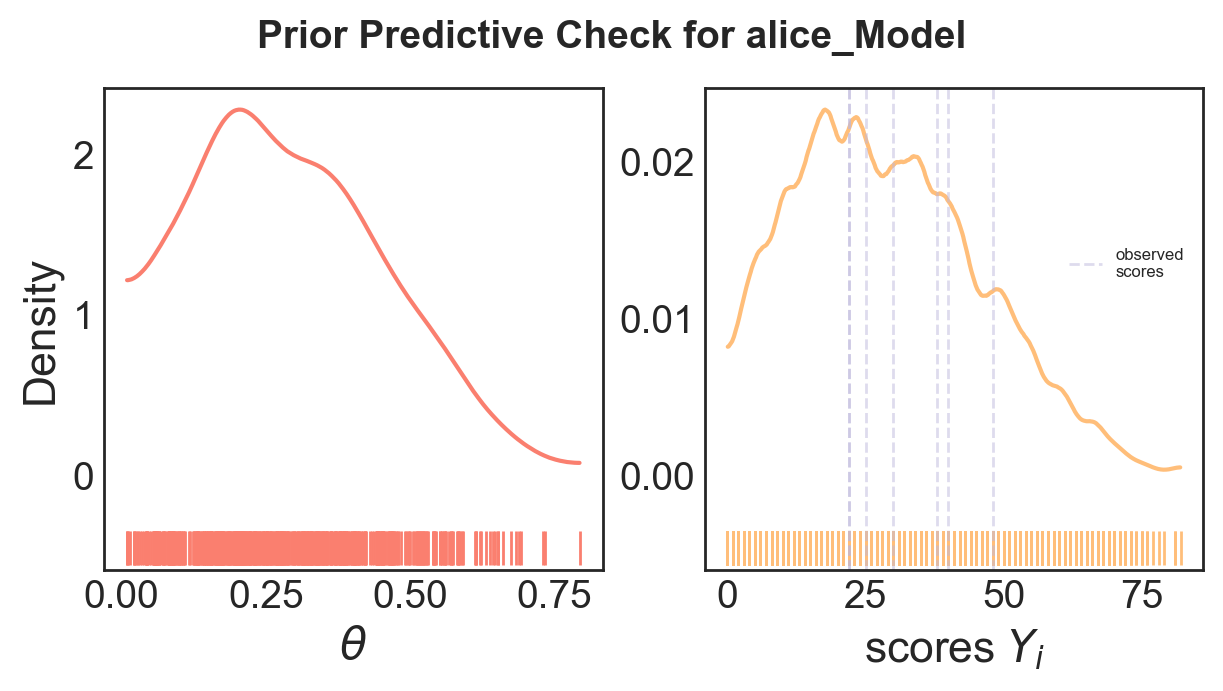

In [19]:
# prior check
with alice_model:
    prior_alice = pm.sample_prior_predictive() # sample from the prior distribution

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fs = 16

# plot prior
az.plot_dist(prior_alice.prior["theta"].values.flatten(), ax=axes[0], kind="kde",color=re, rug=True)
axes[0].set_xlabel(r"$\theta$", fontsize=fs)
axes[0].set_ylabel("Density", fontsize=fs)

# plot prior predictive
az.plot_dist(prior_alice.prior_predictive["y"].values.flatten(), ax=axes[1], kind="kde",color=ye, rug=True)
for li in range(len(obscore)):
    axes[1].axvline(x=obscore[li], color= pu, linestyle='--', linewidth=1, alpha = 0.5);
axes[1].axvline(x=obscore[0], color= pu, linestyle='--', linewidth=1, alpha = 0.5, label='observed\nscores');
axes[1].legend(bbox_to_anchor=(0.7, 0.7), fontsize=6)
axes[1].set_xlabel(r"scores $Y_i$", fontsize=fs)

fig.suptitle('Prior Predictive Check for alice_Model', fontsize=14, fontweight='bold', fontfamily='arial', y=1.1)
plt.show()


#### 采样与绘制后验分布

In [16]:
with alice_model:
    trace_alice = pm.sample()
    
# az.summary(trace_alice)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


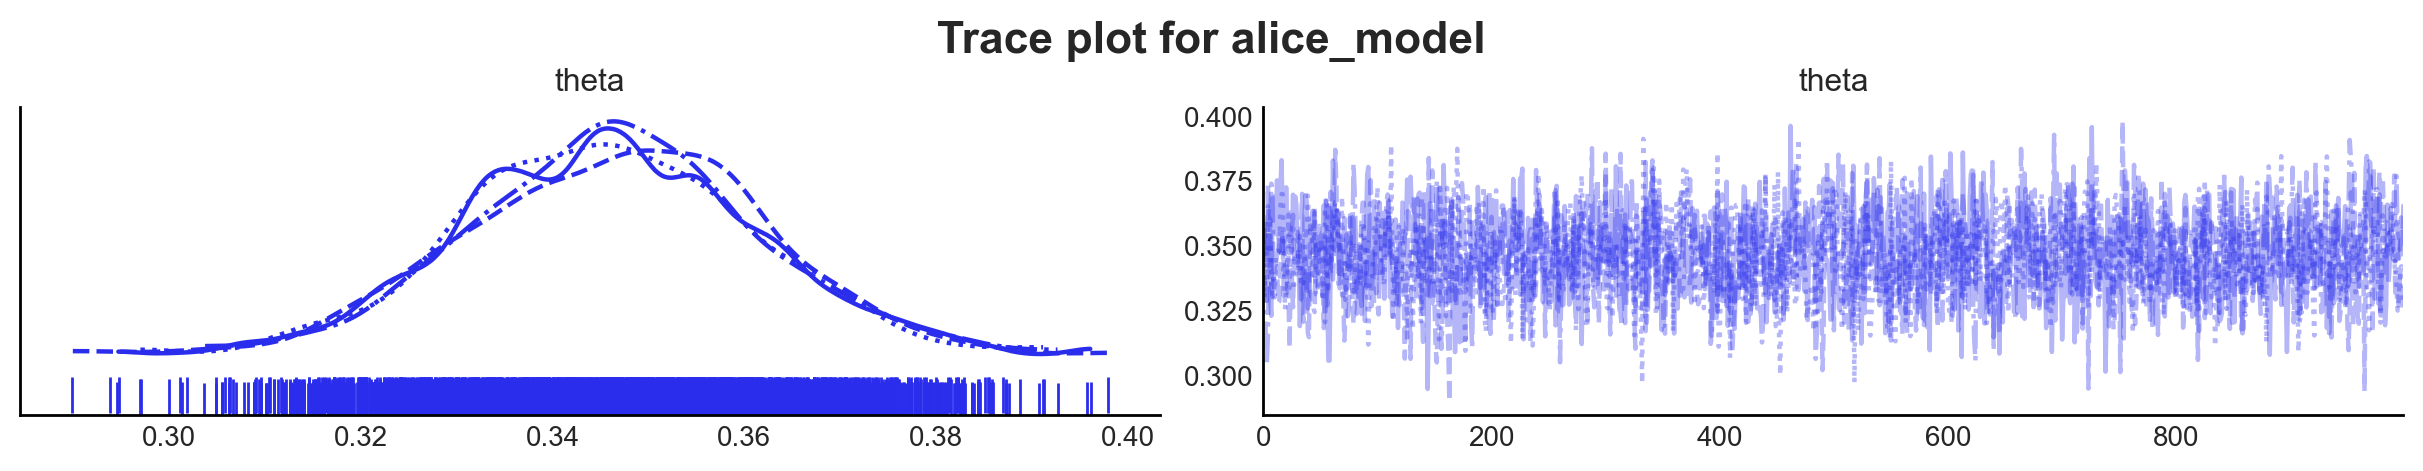

In [189]:
# Trace plot
az.style.use("arviz-white");
az.plot_trace(trace_alice, rug=True)
plt.suptitle('Trace plot for alice_model', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);

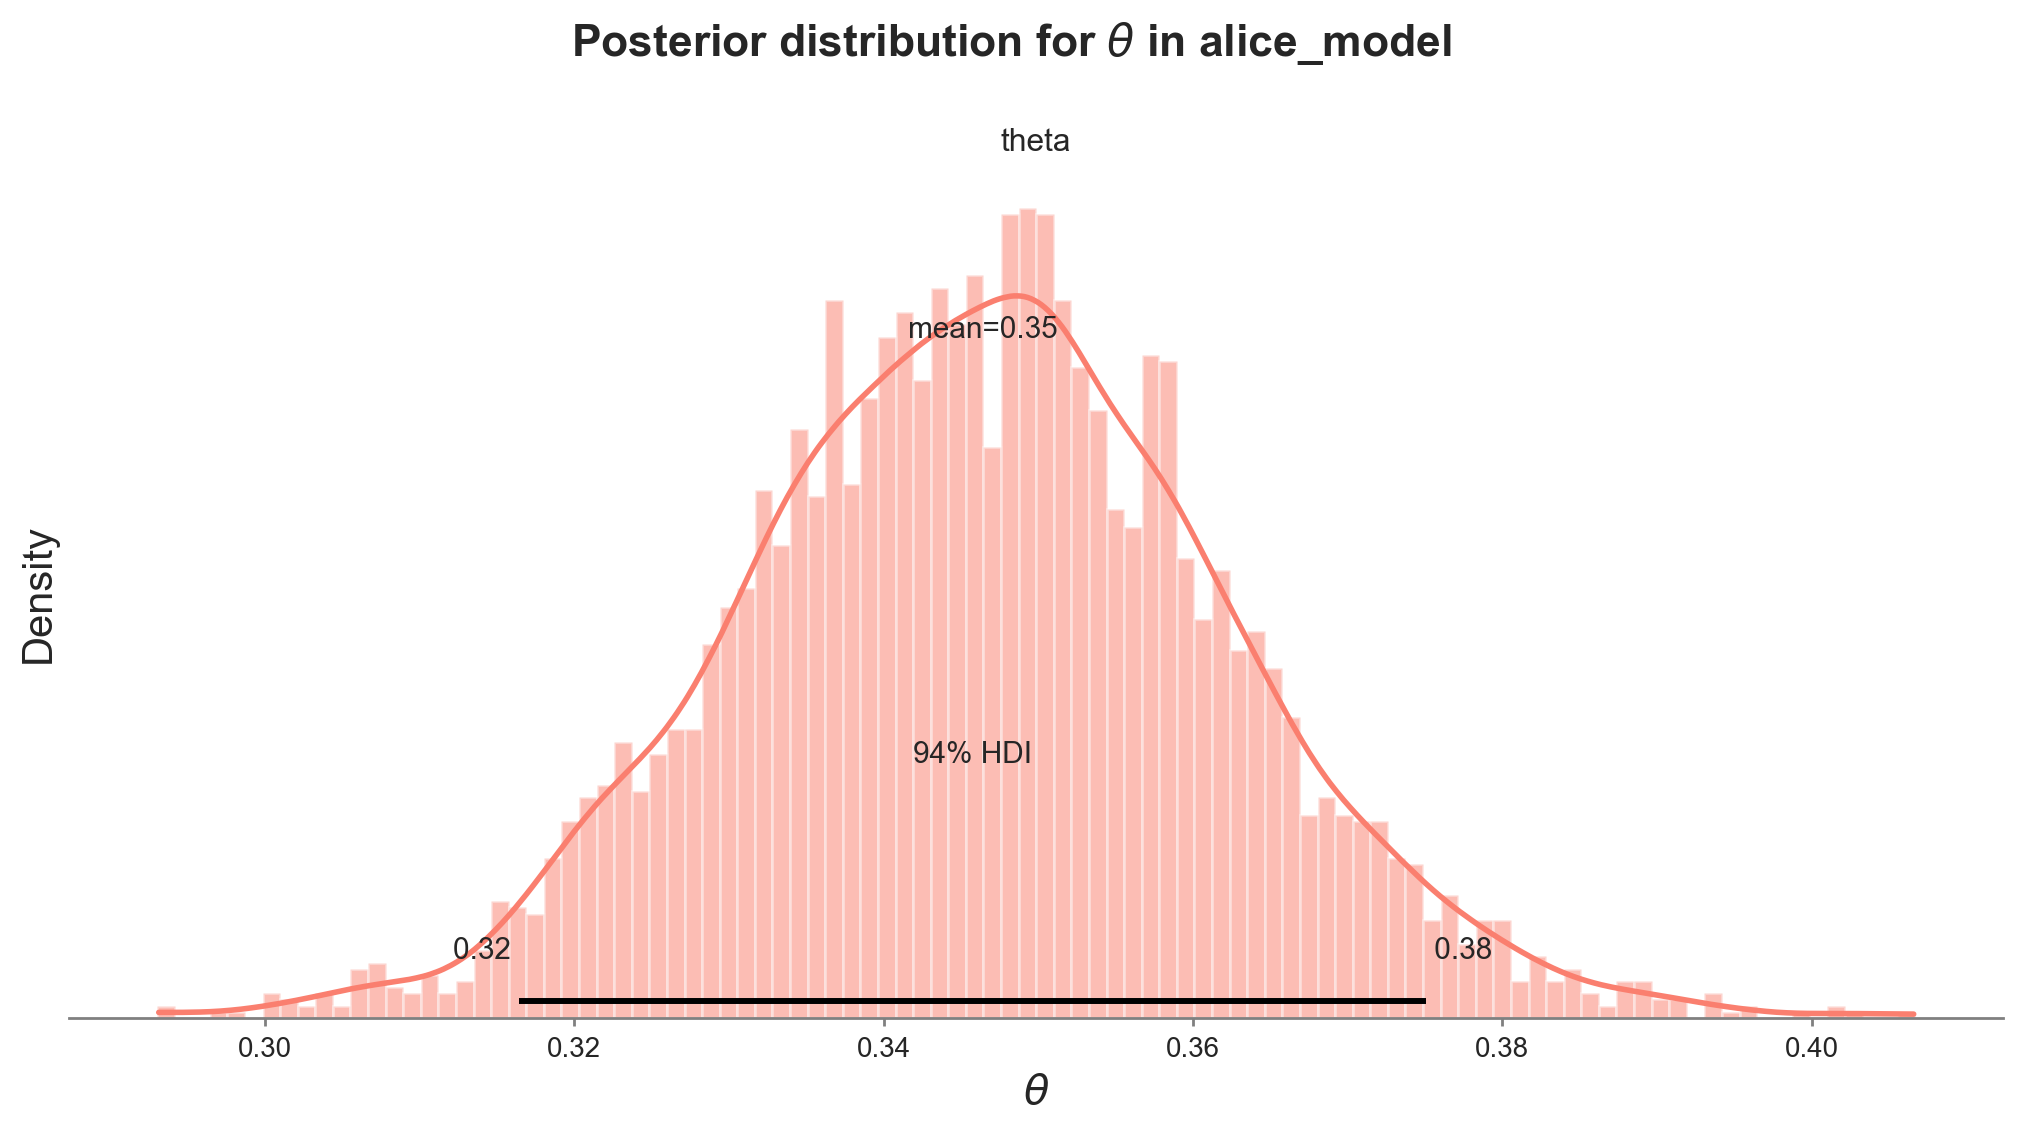

In [20]:
az.style.use("arviz-white");
fig, axes = plt.subplots(1, 1, figsize=(10, 5),dpi=100);

[posterior_theta_alice] = [trace_alice.posterior["theta"].values.flatten()];    # read posterior samples and flatten
az.plot_kde(posterior_theta_alice, ax=axes, plot_kwargs={"color": re, "linewidth": 2});
axes.hist(posterior_theta_alice, bins=100, density=1, alpha=0.3, color=re);
axes.set_xlabel(r"$\theta$");
axes.set_ylabel("Density");

az.plot_posterior(trace_alice, var_names=["theta"], ax=axes, color=re, textsize=10, point_estimate='mean');
axes.set_xlabel(r"$\theta$");
axes.hist(posterior_theta_alice, bins=100, density=1, alpha=0.3, color=re);

fig.suptitle('Posterior distribution for $\\theta$ in alice_model', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);
plt.show()

#### 报告

In [21]:
az.summary(trace_alice, var_names=["theta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.346  0.016   0.316    0.375        0.0      0.0    1367.0    2648.0   

       r_hat  
theta    1.0

由上可知，$\hat\theta$ 的Bayesian估计值为0.347，94%HDI为 $[0.319,0.375]$ ，与MLE相差不大。

### Q3 
为了判断Alice是不是真的掌握了题目中的知识，我们将答对题目的概率$\theta$与几率水平($H_0: \theta=0.25$)进行比较。
1. 请使用 Savage-Dickey density ratio test (Section 7.6)，从$\theta$的后验分布中抽取500个sample，并作kernel平滑，计算假设$H_0: \theta=0.25$与$H_1: \theta\sim \text{Be}(2, 5)$的Bayes factor（重复50次）, 并描述相应结果。
2. 我们同样可以直接从先验分布中抽取样本，计算Bayes factor。根据定义，有$$BF_{10}=\frac{P(D|H_1)}{P(D|H_0)}=\frac{\int{P(D|\theta, H_1)P(\theta|H_1)}d{\theta}}{P(D|H_0)}$$请根据题目中的先验分布，抽取参数样本（500个）计算likelihood，求出Bayes factor（重复50次），与Savage-Dickey test的结果进行比较，并画出相应结果。

---

#### Savage-Dickey density ratio test

- 首先，我们从posterior中抽样500个 $\theta$ 作为sample，采用kde的方式估计出H0对应的 $\theta_0$ 的density作为分子；
- 然后再计算 $\theta \sim Beta(2,5)$ 的prior下其对应的density作为分母，得到Savage-Dickey density ratio test的结果；
- 以上过程重复50次，最后输出得到的Bayes Factor均值。

In [22]:
# Calculate the Savage-Dickey density ratio from posterior
n_repeats = 50
BF_list_pos = []

theta0 = 0.25; 
theta0_at_prior = stats.beta(2,5).pdf(theta0)

for i in range(n_repeats):
    # sample from the posterior
    theta_sample = np.random.choice(posterior_theta_alice, size=500, replace=True)
    
    # calculate the density ratio
    [density_at_theta0] = stats.gaussian_kde(theta_sample).evaluate(theta0)
    
    # calculate the Bayes factor
    BF_list_pos.append(theta0_at_prior/density_at_theta0)
    
BF_pos = np.mean(BF_list_pos)
print('The Savage-Dickey density ratio is %.3g'%(BF_pos))

# plot the demographic data
# fig,ax = plt.subplots(1,1,figsize=(6,4),dpi=100);
# az.plot_kde(posterior_theta_alice, plot_kwargs={"color": re, "linewidth": 2}, ax=ax);
# prior_list = stats.beta(2,5).rvs(size=1000)
# az.plot_kde(prior_list, plot_kwargs={"color": bl, "linewidth": 2}, ax=ax);


The Savage-Dickey density ratio is 8.28e+40


因为这里H0其实是嵌套在H1里的，也可以借助arviz包中的az.plot_bf进行可视化，得到的Bayes Factor与计算的量级一致。

The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


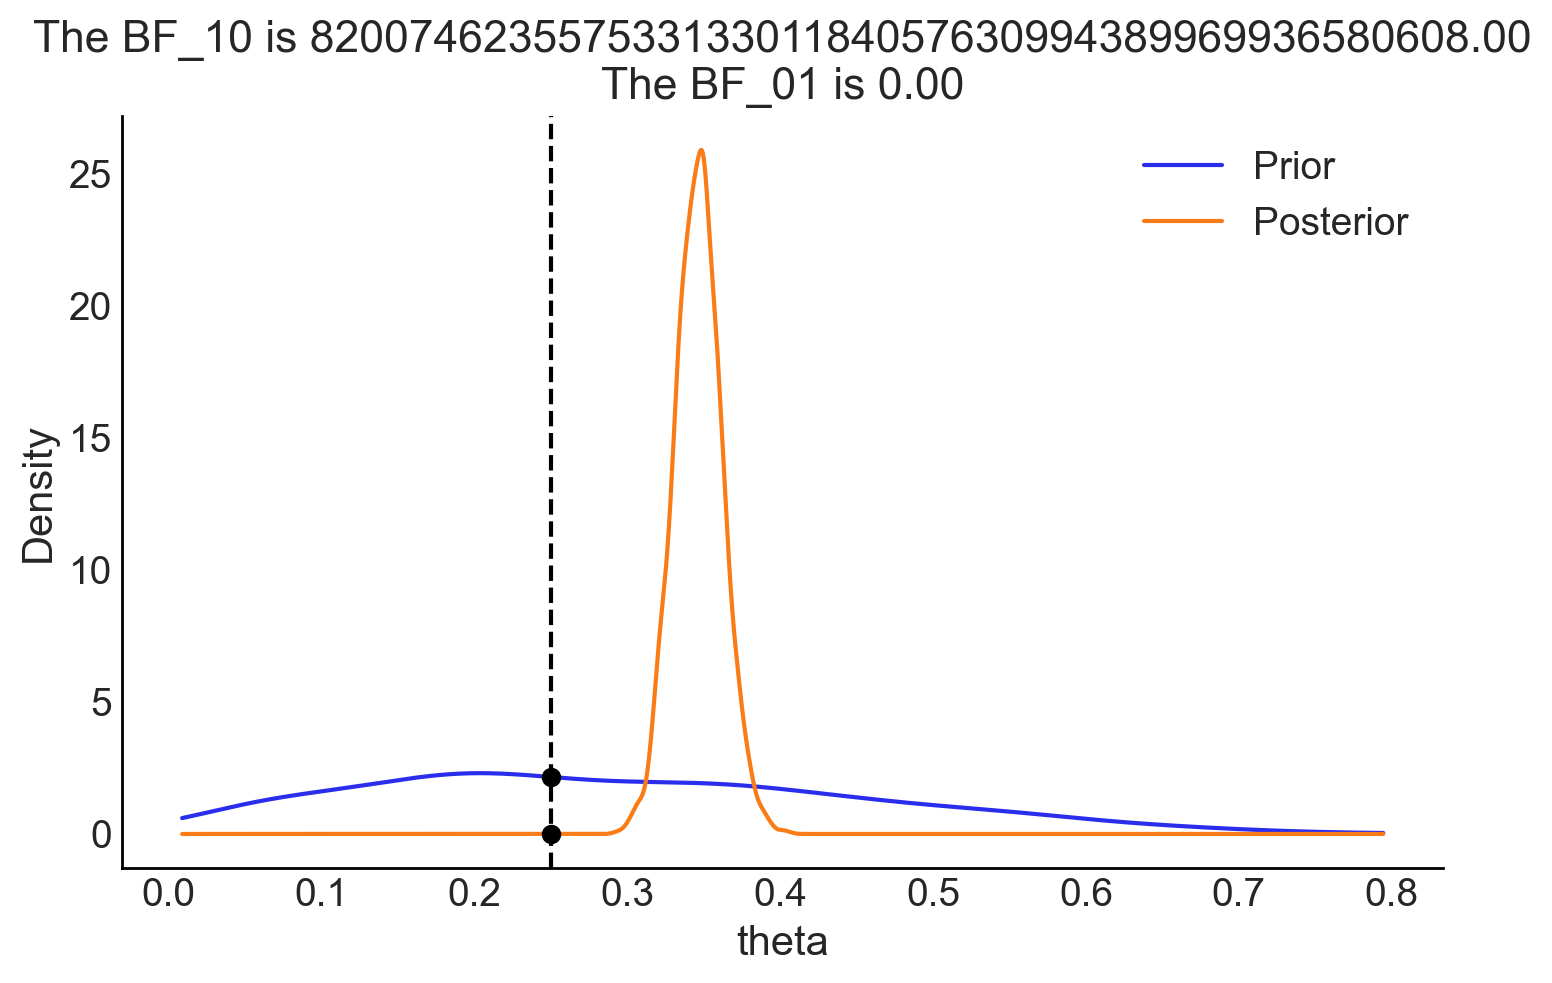

In [23]:
trace_alice.extend(prior_alice)
az.plot_bf(trace_alice, var_name="theta", ref_val=0.25);

#### Bayes Factor calculated by likelihood

然后我们从先验中采样，通过计算似然比的方式计算Bayes Factor：

- 首先，我们从prior中抽样500个 $\theta$ 作为sample，通过前文的似然函数找到 $\theta_i$ 的似然并除以样本量作为分子；
- 然后再计算 $\theta_0$ 的似然作为分母，作除法运算，得到Bayes Factor的结果；
- 以上过程重复50次，最后输出得到的Bayes Factor均值。

In [24]:
# Calculate the Bayes factor from prior
n_repeats = 50
BF_list_pri = [];pri_ll = [];

theta0 = 0.25; 
theta_prior = prior_alice.prior["theta"].values.flatten()
l_h0 = np.exp(-nll_test(theta0, obscore))

for i in range(n_repeats):
    # sample from the posterior
    theta_sample = np.random.choice(theta_prior, size=500, replace=True)
    
    # calculate the density ratio
    ll = 0;
    for i in range(len(theta_sample)):
        ll +=  np.exp(-nll_test(theta_sample[i], obscore))/len(theta_sample)
    
    # calculate the Bayes factor
    BF_list_pri.append(ll/l_h0)
    pri_ll.append(ll)
    
    
BF_pri = np.mean(BF_list_pri)
print('The Bayes factor $BF_{01}$ is %.2f'%BF_pri, '$BF_{10}$ = %.3g'%(1/BF_pri))


The Bayes factor $BF_{01}$ is 345987454.58 $BF_{10}$ = 2.89e-09


#### 报告

未来更加直观的表示两种方法的计算过程和比较结果，我们可以将两种方法的结果进行可视化：
- 在左侧绘制从先验和后验中采样得到的 $\theta$ 的密度分布，并标注出其中H0对应的 $\theta_0$ 的位置，下方则是由比例得到的Bayes Factor的分布；
- 在右侧绘制原本的 $\theta$ 在各个取值下得到的likelihood（红色），以及从先验采样得到的 $\theta$ 所计算出来的Likelihood（蓝色）的密度分布，下方则是由likelihood比例得到的Bayes Factor的分布。

两种方法下得到的BF虽然差距略远，但都远远大于100，比较极端的偏向于另一种假设，可以认为H0被否定，即Alice掌握了题目中的知识。

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:33: RuntimeWarning: divide by zero encountered in log
  nll += -np.sum(np.log(stats.binom(questionnum,theta).pmf(allscores)))
/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/1598959262.py:20: RuntimeWarning: divide by zero encountered in log
  return (np.log(L_likelihood)*Ltime + np.log(U_likelihood)*Utime) # log-likelihood of the lower and upper bounds
/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_39517/3620841397.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


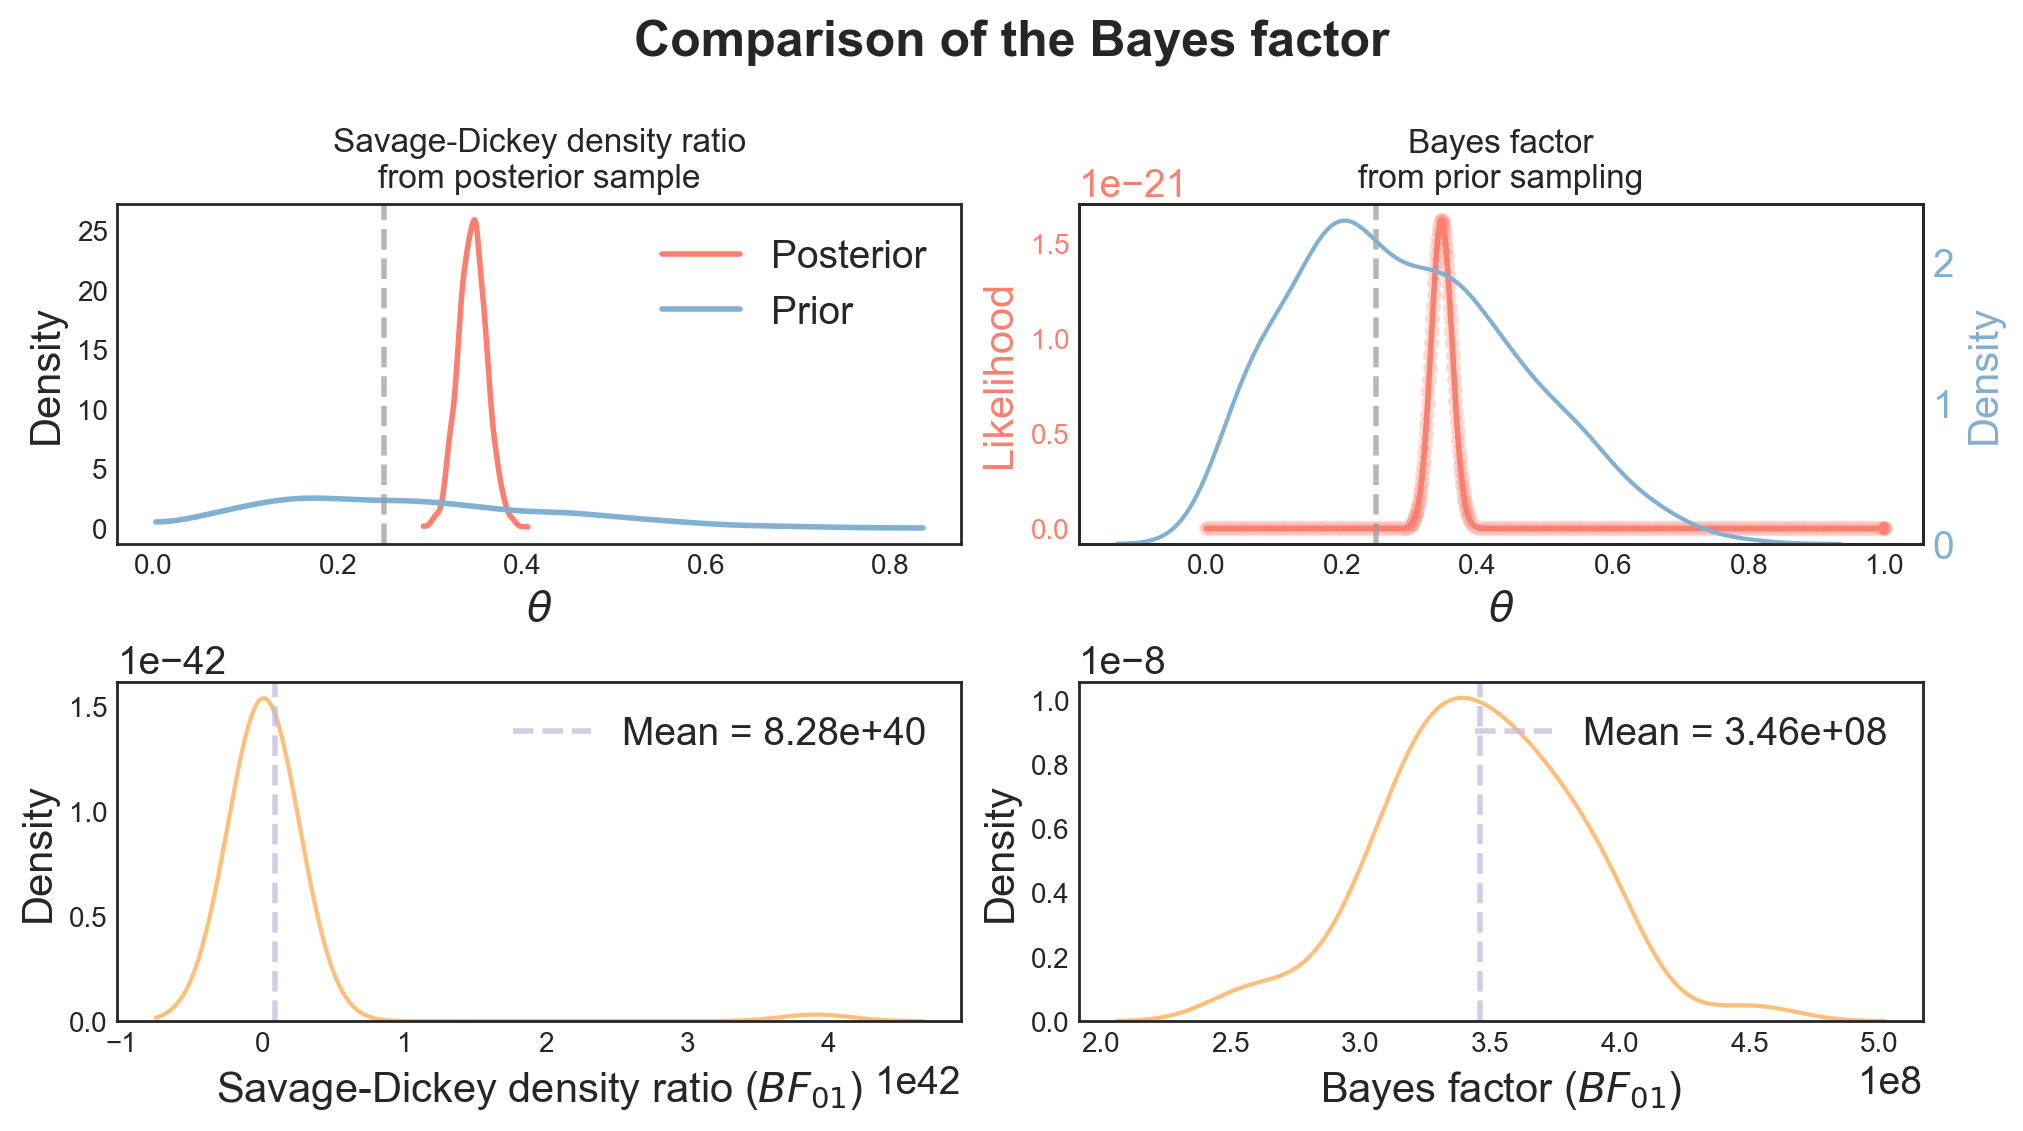

In [26]:
sns.set_style("white");

# plot the comaparison
fig, axes = plt.subplots(2, 2, figsize=(10, 5));

az.plot_kde(posterior_theta_alice, plot_kwargs={"color": re, "linewidth": 2}, ax=axes[0,0],label='Posterior');
prior_list = stats.beta(2,5).rvs(size=1000)
az.plot_kde(prior_list, plot_kwargs={"color": bl, "linewidth": 2}, ax=axes[0,0],label='Prior');
axes[0,0].axvline(x=0.25, color= ak, linestyle='--', linewidth=2, alpha = 0.7);
axes[0,0].set_xlabel(r"$\theta$");
axes[0,0].set_ylabel("Density");
axes[0,0].legend();
axes[0,0].set_title('Savage-Dickey density ratio\nfrom posterior sample', fontsize = 12);


sns.kdeplot(BF_list_pos, color = ye, ax=axes[1,0]);
axes[1,0].set_xlabel("Savage-Dickey density ratio ($BF_{01}$)");
axes[1,0].axvline(x=BF_pos, color= pu, linestyle='--', linewidth=2, alpha = 0.7, label='Mean = %.3g'%BF_pos);
axes[1,0].legend();

theta_lst = np.linspace(0,1,1000);
likelihood_lst = [];
for ti in range(len(theta_lst)):
    likelihood_lst.append(np.exp(-nll_test(theta_lst[ti], obscore)));

df = pd.DataFrame({'theta':theta_lst, 'likelihood':likelihood_lst});
sns.scatterplot(x='theta', y='likelihood', data=df, s=30, color=re, alpha=0.3, ax=axes[0,1]);  
axes[0,1].tick_params(axis='y', labelcolor=re);
axes[0,1].plot(df['theta'], df['likelihood'], color = re, alpha = 1, linewidth = 2, label='Likelihood');
axes[0,1].axvline(x=0.25, color= ak, linestyle='--', linewidth=2, alpha = 0.7);
axes[0,1].set_xlabel(r"$\theta$");
axes[0,1].set_ylabel("Likelihood", color=re);
axes[0,1].set_title('Bayes factor\nfrom prior sampling', fontsize = 12);
axshare = axes[0,1].twinx()  
sns.kdeplot(theta_prior, color = bl, ax=axshare, label='prior');
axshare.tick_params(axis='y', labelcolor=bl);
axshare.set_ylabel('Density', color=bl);


sns.kdeplot(BF_list_pri, color = ye, ax=axes[1,1]);
axes[1,1].set_xlabel("Bayes factor ($BF_{01}$)");
axes[1,1].axvline(x=BF_pri, color= pu, linestyle='--', linewidth=2, alpha = 0.7, label='Mean = %.3g'%BF_pri);
axes[1,1].legend(loc='upper right');

for ax in axes.flatten():
    ax.tick_params(axis='both', which='both', labelsize = 10) # set the tick size

fig.suptitle('Comparison of the Bayes factor', fontsize=18, fontweight='bold', fontfamily='arial', y=1.1);
fig.show()


## 题目三

在two-country quiz problem中，一组数据为'homework3_q3.csv'。对题目和答题者有以下两种假设：
* $H_1$：答题者包括泰国人和摩尔多瓦人，题目除了泰国历史题和摩尔多瓦历史题外，还有英国历史题。设泰国人和摩尔多瓦人对英国历史题的答题正确率均为$\gamma$，已知泰国人和摩尔多瓦人回答英国历史题的正确率均低于回答本国历史题的正确率($\gamma < \alpha$)；
* $H_2$：题目包括泰国历史题和摩尔多瓦历史题，答题者除了泰国人和摩尔多瓦人外，还有英国人。设英国人对泰国历史题和摩尔多瓦历史题的答题正确率均为$\zeta$，已知英国人回答两国历史题的正确率均低于本国人回答本国题目的正确率 ($\zeta < \alpha$)

### Q1
请为$\gamma$和$\zeta$设置恰当的先验分布，并画出$H1$和$H_2$的graphical model

---

#### 分析数据与建模

In [2]:
# load the data from the csv file and take a look
dt = pd.read_csv('homework3_q3.csv', header = 0 ) # load the data from the csv file 
scores = dt.values[:,0:-1];
[personn, quizn] = scores.shape;
dt.head() # take a look at the data

a  b  c  d  e  f  g  h  person
0  1  0  0  1  1  1  0  1       1
1  1  0  0  0  1  0  0  1       2
2  0  1  1  0  0  1  0  0       3
3  0  1  1  0  0  1  1  0       4
4  0  0  0  1  1  0  0  1       5

根据题目设置，我们可知一下条件：
* $\beta < \alpha, \gamma < \alpha, \zeta < \alpha$
* $\beta, \gamma, \zeta \in [0,1]$
* H1假设下，每道题目有三种可能类型，被试有两种可能类型，因此有$3\times 2 = 6$种可能的组合，即$6$种可能的$\theta$；
* H2假设下，每道题目有两种可能类型，被试有三种可能类型，因此有$2\times 3 = 6$种可能的组合，即$6$种可能的$\theta$；

据此，我们可以构建如下的两个模型。两个模型中，分别假设每个人和每道题目的所属国家，综合确定了$\theta$的取值，并进一步决定的得到的分数的分布。

由于不知道具体的参数取值，我们假设一个约束性并不强的均匀先验，即 $\alpha \sim \text{Uniform}(0,1)$ ,$\beta \sim \text{Uniform}(0,\alpha)$, $\gamma \sim \text{Uniform}(0,\alpha)$,$\zeta\sim \text{Uniform}(0,\alpha)$ 。

可以由以下的代码和结构图表示：

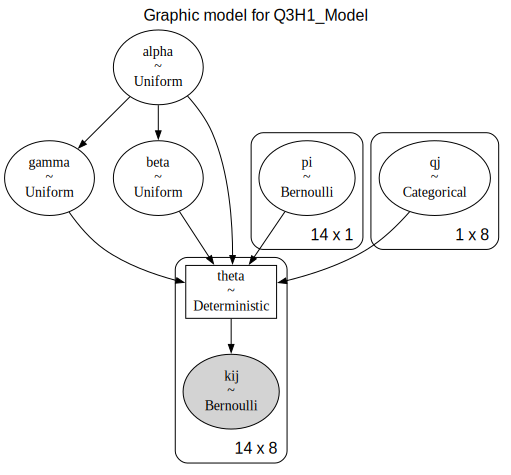

In [3]:
with pm.Model() as Q3H1_Model:
    # prior
    alpha1 = pm.Uniform("alpha", lower=0., upper=1.)
    beta1 = pm.Uniform("beta", lower=0., upper=alpha1)
    gamma = pm.Uniform("gamma", lower=0., upper=alpha1)

    # set p of xi to be 1 for the first row and 0.5 for the rest
    pi1 = pm.Bernoulli("pi", p=np.array([1]+[0.5]*(personn-1)).reshape(-1, 1), shape=(personn, 1)) # shape = (personn, 1) (personn, 1) what country is the person from
    qj1 = pm.Categorical("qj", p=np.array([1/3, 1/3, 1/3]), shape=(1, quizn)) # shape = (1, quizn) what country is the question about
    
    # accuracy prior
    theta1 = pm.Deterministic("theta", pt.switch(pt.eq(qj1,2), gamma, pt.switch(pt.eq(pi1,qj1), alpha1, beta1))) 
    # if english quiz, then gamma, if same country, then alpha, else beta
    
    # observed
    kij1 = pm.Bernoulli("kij", p=theta1, observed=scores) # shape = (personn, quizn)
    
graphm = pm.model_to_graphviz(Q3H1_Model) # model graph
graphm.graph_attr.update({
    'label': 'Graphic model for Q3H1_Model',  # add label to the top
    'labelloc': 't',      # set label location to top
    'labeljust': 'c',     # set label justification to center
    'fontname':'Arial',   # set font to Arial
    'fontsize':'16'      # set font size to 16
})
graphm.node_attr.update({'fontsize': '14'})
graphm.edge_attr.update({'arrowsize': '0.8'})

graphm

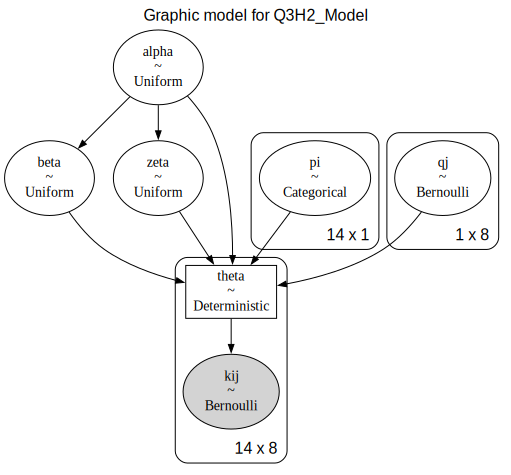

In [4]:
with pm.Model() as Q3H2_Model:
    # prior
    alpha2 = pm.Uniform("alpha", lower=0., upper=1.)
    beta2 = pm.Uniform("beta", lower=0., upper=alpha2)
    zeta = pm.Uniform("zeta", lower=0., upper=alpha2)

    # set p of xi to be 1 for the first row and 0.5 for the rest
    pi2 = pm.Categorical("pi", p=np.array([1/3, 1/3, 1/3]), shape=(personn, 1)) # shape = (personn, 1) what country is the person from
    qj2 = pm.Bernoulli("qj", p=np.array([1]+[0.5]*(quizn-1)).reshape(1, -1), shape=(1, quizn)) # shape = (1, quizn) if the question is english or not
    
    # accuracy prior
    theta2 = pm.Deterministic("theta", pt.switch(pt.eq(pi2,2), zeta, pt.switch(pt.eq(pi2,qj2), alpha2, beta2))) 
    # shape = (personn, quizn) if english person, then zeta, if same country, then alpha, else beta
    
    # observed
    kij2 = pm.Bernoulli("kij", p=theta2, observed=scores) # shape = (personn, quizn)
    
graphm = pm.model_to_graphviz(Q3H2_Model) # model graph
graphm.graph_attr.update({
    'label': 'Graphic model for Q3H2_Model',  # add label to the top
    'labelloc': 't',      # set label location to top
    'labeljust': 'c',     # set label justification to center
    'fontname':'Arial',   # set font to Arial
    'fontsize':'16'      # set font size to 16
})
graphm.node_attr.update({'fontsize': '14'})
graphm.edge_attr.update({'arrowsize': '0.8'})

graphm

### Q2
对本题数据分别运行$H_1$和$H_2$对应的模型，请在答案中
1. 对$H_1$，分别画出$\alpha$、$\beta$和$\gamma$的后验分布；
2. 对$H_2$，分别画出$\alpha$、$\beta$和$\zeta$的后验分布；
3. 报告两个模型相应的convergence指标。

---

#### 采样

我们首先对两个模型进行采样，每个模型中都是先确定 $\alpha$，所以设置一定的顺序。

需要注意的是，默认情况下的每条链采样1000次时，H2的模型的各个参数的后验分布的方差都很大，没有很好地收敛。

因此我们每条链的采样次数增加到2000次，这样可以使得每条链的采样次数相对较多，从而使得后验分布的方差变小。

In [5]:
with Q3H1_Model:
    step = pm.Slice([alpha1, beta1, gamma])
    trace_H1 = pm.sample(step=step, draws=2000)
    pm.compute_log_likelihood(trace_H1)

# az.summary(trace_H1, var_names=['alpha', 'beta', 'gamma'])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [gamma]
>BinaryGibbsMetropolis: [pi]
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [gamma]
>BinaryGibbsMetropolis: [pi]
>CategoricalGibbsMetropolis: [qj]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
with Q3H2_Model:
    step = pm.Slice([alpha2, beta2, zeta])
    trace_H2 = pm.sample(step=step, draws=2000)
    pm.compute_log_likelihood(trace_H2)

# az.summary(trace_H2, var_names=['alpha', 'beta', 'zeta'])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [zeta]
>CategoricalGibbsMetropolis: [pi]
CompoundStep
>CompoundStep
>>Slice: [alpha]
>>Slice: [beta]
>>Slice: [zeta]
>CategoricalGibbsMetropolis: [pi]
>BinaryGibbsMetropolis: [qj]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### 绘制后验分布

我们将两个模型的后验分布绘制在同一张图中进行比较，并将 $\alpha$、$\beta$ 对应的x轴坐标设置为相同，将 $\gamma$ 和 $\zeta$ 的的x轴坐标设置为相同，结果如图所示。

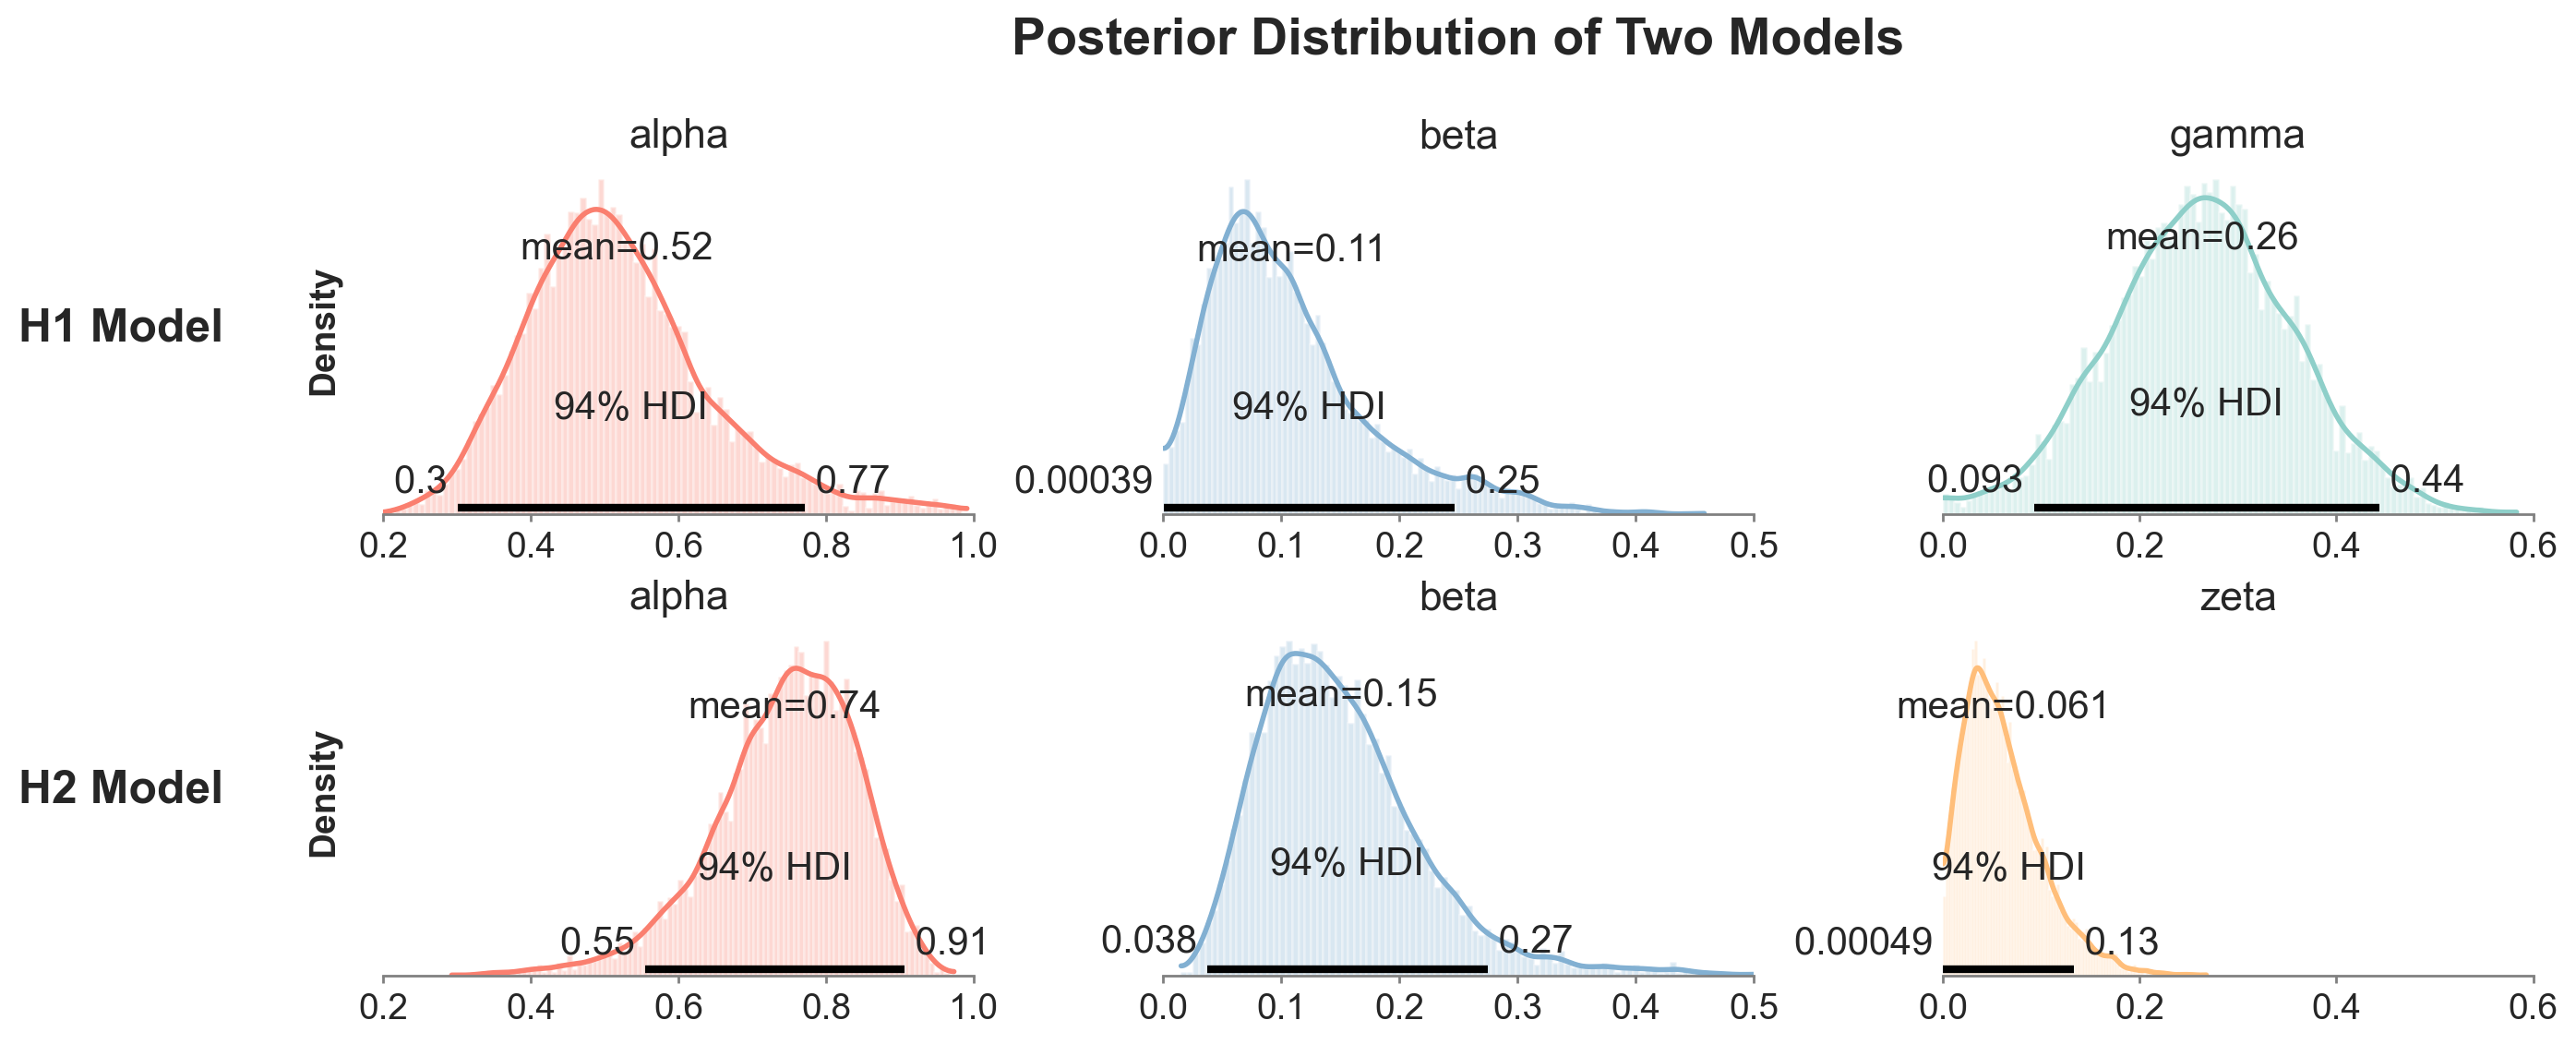

In [7]:
# plot the posterior distribution of alpha, beta, gamma
sns.set_style("white");
fig, axes = plt.subplots(2,3, figsize = [12,5], dpi=100)

[posterior_alpha, posterior_beta, posterior_gamma] = [trace_H1.posterior["alpha"].values.flatten(), trace_H1.posterior["beta"].values.flatten(), trace_H1.posterior["gamma"].values.flatten()]
[pos_alpha, pos_beta, pos_zeta] = [trace_H2.posterior["alpha"].values.flatten(), trace_H2.posterior["beta"].values.flatten(), trace_H2.posterior["zeta"].values.flatten()]

az.plot_posterior(trace_H1, var_names=["alpha"], ax=axes[0,0], color= re);
az.plot_kde(posterior_alpha, ax=axes[0,0], plot_kwargs={"color": re, "linewidth": 2});
axes[0,0].hist(posterior_alpha, bins=100, density=1, alpha=0.3, color=re);
axes[0,0].set_xlim(0.2,1.0);
az.plot_posterior(trace_H1, var_names=["beta"], ax=axes[0,1], color=bl);
az.plot_kde(posterior_beta, ax=axes[0,1], plot_kwargs={"color": bl, "linewidth": 2});
axes[0,1].hist(posterior_beta, bins=100, density=1, alpha=0.3, color=bl);
axes[0,1].set_xlim(0.0,0.5);
az.plot_posterior(trace_H1, var_names=["gamma"], ax=axes[0,2], color=gr);
az.plot_kde(posterior_gamma, ax=axes[0,2], plot_kwargs={"color": gr, "linewidth": 2});
axes[0,2].hist(posterior_gamma, bins=100, density=1, alpha=0.3, color=gr);
axes[0,2].set_xlim(0.0,0.6);
az.plot_posterior(trace_H2, var_names=["alpha"], ax=axes[1,0], color=re);
az.plot_kde(pos_alpha, ax=axes[1,0], plot_kwargs={"color": re, "linewidth": 2});
axes[1,0].hist(pos_alpha, bins=100, density=1, alpha=0.3, color=re);
axes[1,0].set_xlim(0.2,1.0);
az.plot_posterior(trace_H2, var_names=["beta"], ax=axes[1,1], color=bl);
az.plot_kde(pos_beta, ax=axes[1,1], plot_kwargs={"color": bl, "linewidth": 2});
axes[1,1].hist(pos_beta, bins=100, density=1, alpha=0.3, color=bl);
axes[1,1].set_xlim(0.0,0.5);
az.plot_posterior(trace_H2, var_names=["zeta"], ax=axes[1,2], color=ye);
az.plot_kde(pos_zeta, ax=axes[1,2], plot_kwargs={"color": ye, "linewidth": 2});
axes[1,2].hist(pos_zeta, bins=100, density=1, alpha=0.3, color=ye);
axes[1,2].set_xlim(0.0,0.6);

fig.text(-0.15, 0.75, 'H1 Model', fontsize=18, fontweight='bold', fontfamily='arial');
fig.text(-0.02,0.7,'Density', fontsize=14, fontweight='bold', rotation=90);
fig.text(-0.15, 0.25, 'H2 Model', fontsize=18, fontweight='bold', fontfamily='arial');
fig.text(-0.02,0.2,'Density', fontsize=14, fontweight='bold', rotation=90);

fig.suptitle('Posterior Distribution of Two Models', fontsize=20, fontweight='bold', fontfamily='arial', y=1.1);
plt.show()

#### 比较模型convergence指标

In [8]:
print('H1 Model Summary')
az.summary(trace_H1, var_names=['alpha', 'beta', 'gamma'])


H1 Model Summary


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.516  0.126   0.301    0.771      0.005    0.004     571.0    1071.0   
beta   0.109  0.071   0.000    0.247      0.003    0.002     957.0    1048.0   
gamma  0.263  0.093   0.093    0.443      0.002    0.001    3350.0    4857.0   

       r_hat  
alpha   1.01  
beta    1.01  
gamma   1.00

In [9]:
print('H2 Model Summary')
az.summary(trace_H2, var_names=['alpha', 'beta', 'zeta'])

H2 Model Summary


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.743  0.098   0.555    0.907      0.004    0.003    1041.0     461.0   
beta   0.151  0.070   0.038    0.275      0.003    0.002     874.0     517.0   
zeta   0.061  0.040   0.000    0.133      0.001    0.000    3698.0    3790.0   

       r_hat  
alpha   1.01  
beta    1.01  
zeta    1.00

Bayesian model的convergence指标是通过Gelman-Rubin收敛诊断得到的，这个方法基于多个马尔可夫链模拟：比较了不同马尔可夫链上的平均值与总体平均值之间的变异程度。如果收敛了，那么这个值应该接近1。

- 在summary的输出中，convergence的指标是$\hat r$，我们可以看到两个模型的 $\hat r$ 都接近于1，说明两个模型都成功收敛了，下面的trace plot中也可以看出，两种模型的各个链都converge得很好。
- 但是前文有提及，H2在每条链1000采样时的收敛性并不好，将采样数提升到每条链2000才得到每个指标都收敛的结果。


另一个指标ESS（effective sample size），是一种度量蒙特卡罗采样的有效样本数量的方法。它考虑到样本之间的自相关性，因此可以更准确地评估样本的数量。如果ESS比总样本数小很多，那么可能需要更多的样本才能达到收敛。
- 从ESS的角度来看，二者在bulk区域，即后验的中间部分，都有很好的收敛性，但是在tail区域，即后验的边缘部分，H2的ESS更大一些，可能是由于H2的模型参数的后验分布的方差更大一些，在分分布边缘的参数范围也比较容易收敛。

总之，二者都收敛得很好，可以认为二者都是可靠的模型。

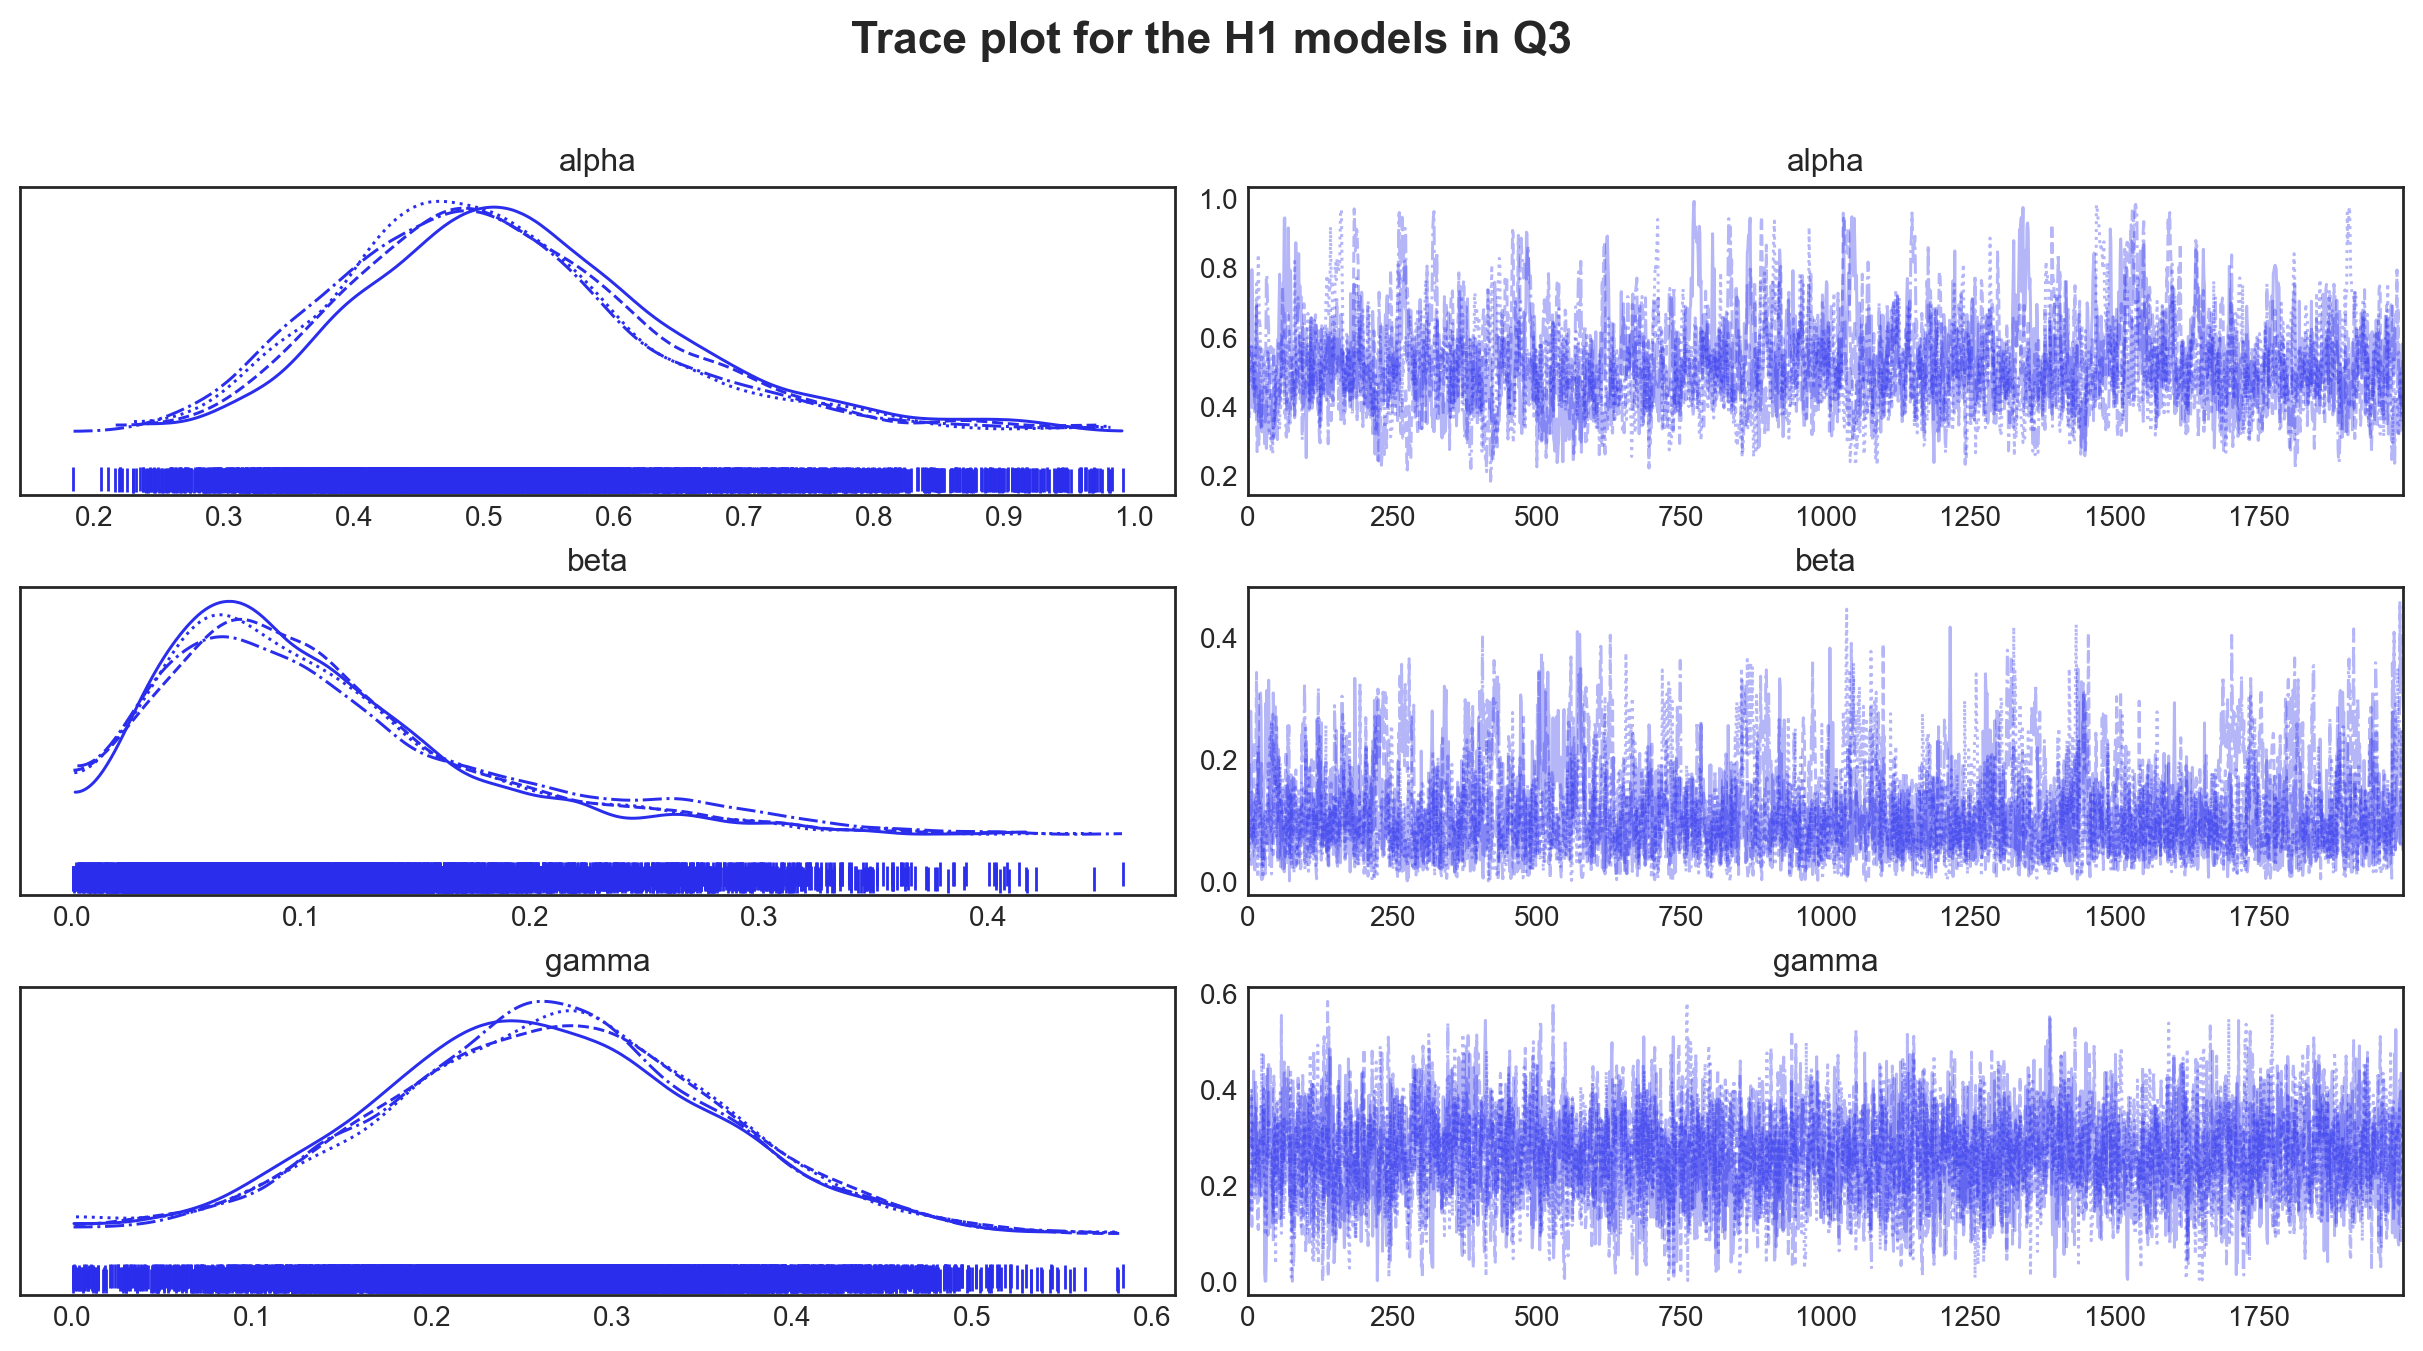

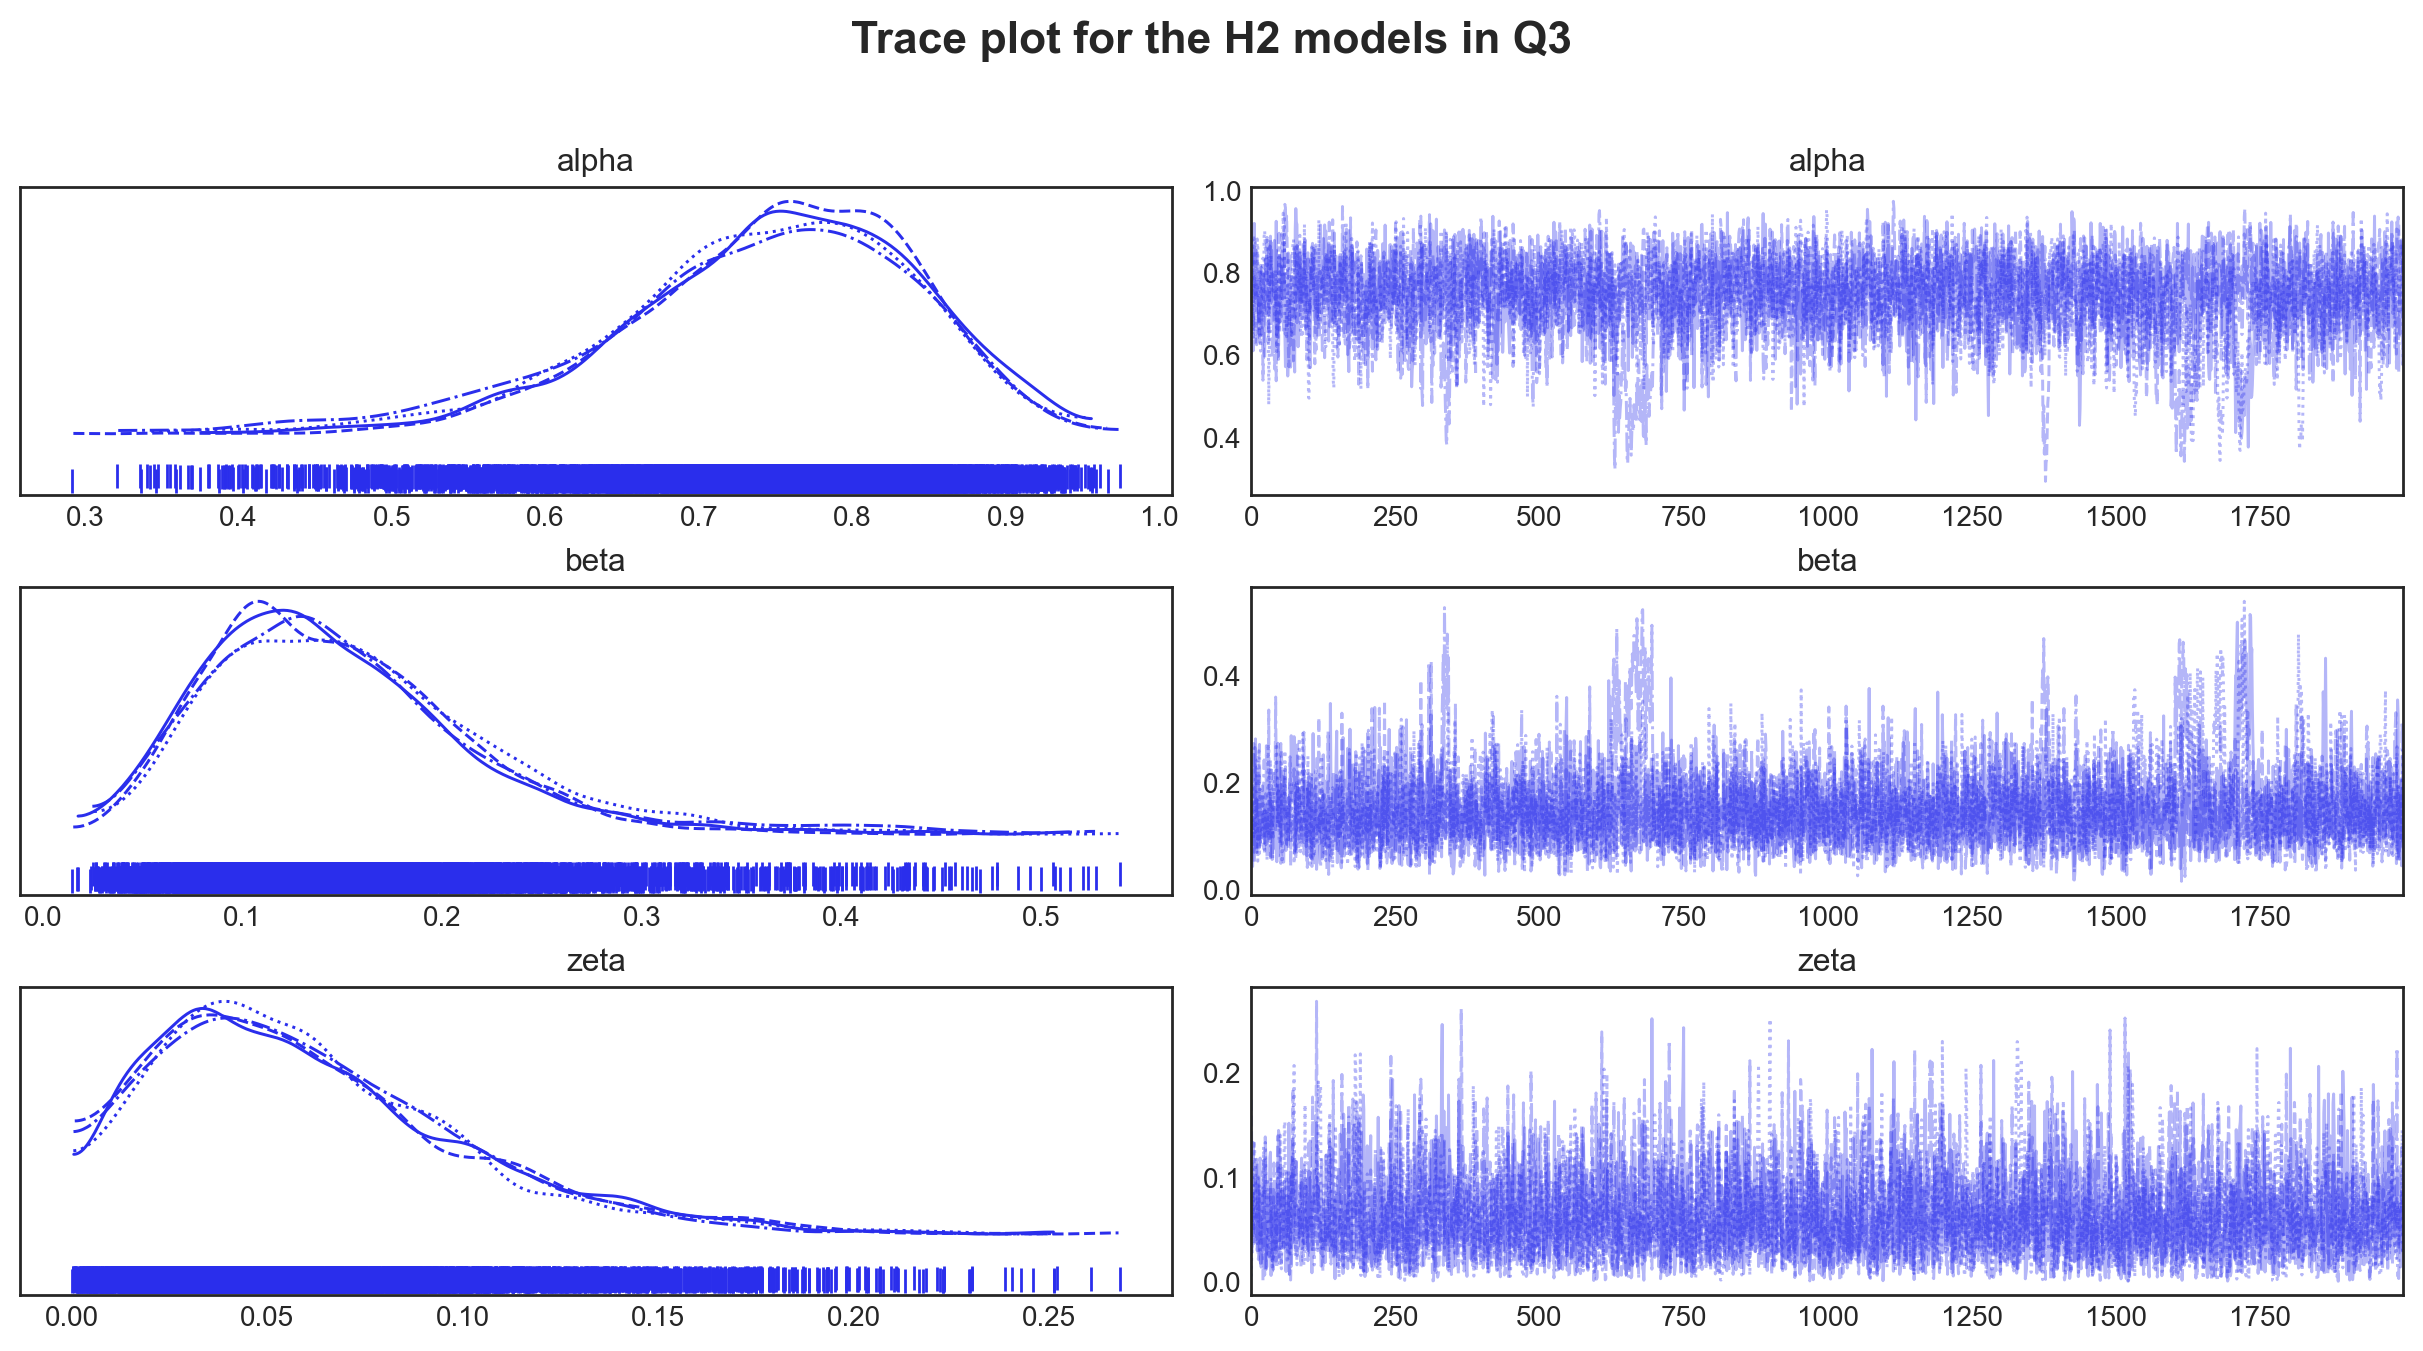

In [13]:
az.plot_trace(trace_H1, var_names=["alpha", "beta", "gamma"], compact=True, rug=True);
plt.suptitle('Trace plot for the H1 models in Q3', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);
az.plot_trace(trace_H2, var_names=["alpha", "beta", "zeta"], compact=True, rug=True);
plt.suptitle('Trace plot for the H2 models in Q3', fontsize=16, fontweight='bold', fontfamily='arial', y=1.1);

### Q3
请比较$H_1$和$H_2$对应模型WAIC，并简单解释比较结果。

---

#### 计算WAIC

Widely Applicable Information Criterion (WAIC)是一种用于比较不同的贝叶斯模型对数据的拟合能力的模型指标。与BIC、AIC等指标不同，WAIC考虑了模型的复杂性，并且可以应用于不同类型的贝叶斯模型。

具体来说，WAIC的计算方法如下：

$$WAIC = -2(log\ \hat{elpd} - p_{WAIC})$$

其中，$\hat{elpd}$ 表示每个观测数据点的elpd的平均值，$p_{WAIC}$ 是模型参数数目的惩罚项。通过对比不同模型的WAIC值，可以选择最适合数据的模型。通常，WAIC值较小的模型意味着更好的预测能力，因此，可以使用WAIC来描述模型相对于同一数据集和先验分布的预测性能，并使用较小的WAIC值来选择最优模型。

对于本题的两个结果来看，，H1的WAIC值为-65.47，H2的WAIC值为-44.62，并且我们的先验设置和数据集基本一致，因此可以认为H2的模型更好地拟合了数据。

即使在上一问中，我们发现H2模型需要更多采样来达到完全收敛，这里的结果表明H2从预测能力上来看更优，更能解释对应数据集的情况。

In [11]:
# your answer here
h1_waic = pm.waic(trace_H1, Q3H1_Model)
h2_waic = pm.waic(trace_H2, Q3H2_Model)
print('WAIC for H1 Model')
print(h1_waic)
print()
print('WAIC for H2 Model')
print(h2_waic)

WAIC for H1 Model
Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -65.10     4.71
p_waic       13.24        -

There has been a warning during the calculation. Please check the results.

WAIC for H2 Model
Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -45.68     6.15
p_waic       10.77        -

There has been a warning during the calculation. Please check the results.


/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


#### 可视化比较

我们也可以绘制模型比较图，如下所示，表明H2相对H1在WAIC上表现更优。

/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


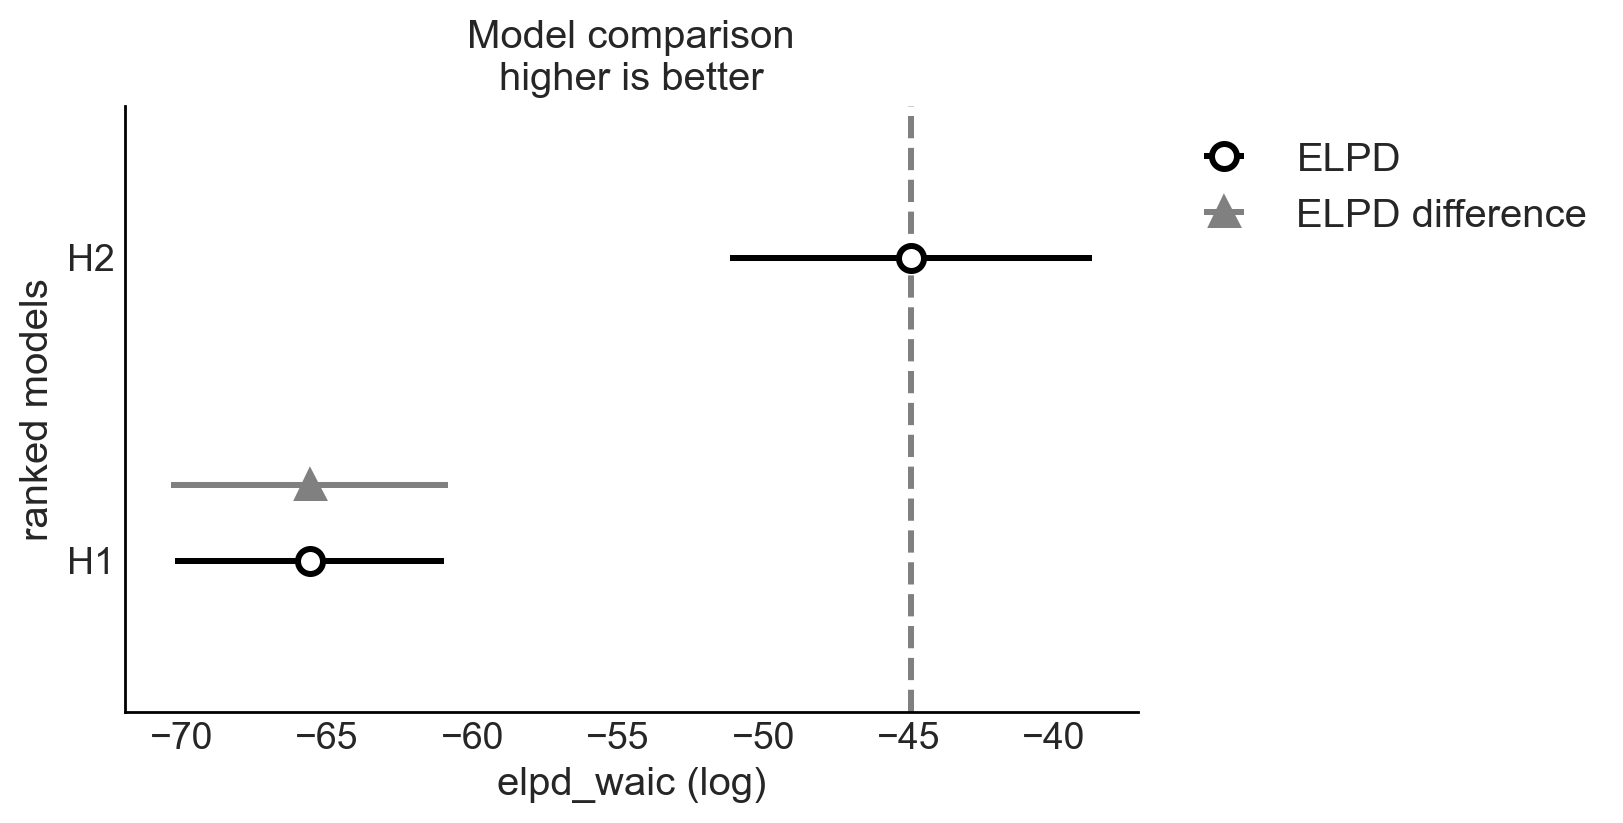

In [197]:
compare_waic = az.compare({'H1': trace_H1, 'H2': trace_H2}, ic='waic')
az.plot_compare(compare_waic, insample_dev=False, figsize=(8, 4));